<div style="text-align:center">
    <h1 style="text-align:center; font-size:50px; margin-bottom: 5px">Fiducial Simulation Analysis</h1>
    <p style="text-align:center;">This notebook demonstrates how to reproduce the plots that examine the fiducial population of Galactic DCOs in Wagg et al. (2021). The two main plots show the distribution of the sources on the LISA sensitivity curve as well as a grid of various parameter distributions. In order to make these plots you'll need the data, which can be found <a href="https://zenodo.org/record/4699713">here</a> on Zenodo.</p>
</div>

In [1]:
# general package imports
import h5py as h5
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
from matplotlib.gridspec import GridSpec
import seaborn as sns

import time

# custom LISA package
import legwork

# import code from repo
import sys
sys.path.append("../../simulation/src/")
from variations import variations
from galaxy import simulate_mw
from seaborn_utility import cmap_from_colour
from verification_binaries import verification_binaries

import bootstrap as boots
import uncertainties as unc

In [2]:
# config stuff to make plots look pretty
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
fs = 20

params = {'legend.fontsize': fs,
         'axes.labelsize': fs,
         'xtick.labelsize':0.7*fs,
         'ytick.labelsize':0.7*fs}
plt.rcParams.update(params)

In [4]:
# define what DCOs we are working with and a colour scheme
dco_types = ["BHBH", "BHNS", "NSNS"]
dco_colours = {"BHBH": plt.get_cmap("plasma")(0.2), 
               "BHNS": plt.get_cmap("plasma")(0.5),
               "NSNS": plt.get_cmap("plasma")(0.8)}

# IMPORTANT: these need to point to the folders where you stored the data from Zenodo
data_folder = "../../simulation/data/"
sim_folder = data_folder + "simulation/"

# load a bunch of data
total_DCOs_in_MW = np.load(data_folder + "total_DCO_in_MW.npy")
detections_4yr = np.load(data_folder + "detections_4yr.npy")
detections_10yr = np.load(data_folder + "detections_10yr.npy")

In [5]:
detections_4yr[:, 0].mean(axis=1).round(2)

array([73.7 , 42.13,  7.87])

# Parameter distributions

## Properties of detectable sources

In [163]:
def distance_distribution(model=0, t_obs=4 * u.yr, bootstraps=200, dco_types=dco_types,
                          colours=dco_colours, save_fig=True, file_name=None,
                          fig=None, ax=None, show=True, legend=True):
    
    start = time.time()

    detection_total = detections_4yr if t_obs == 4 * u.yr else detections_10yr
    
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))
    lw = 4
    
    # loop over each DCO type
    for i, dco_type in enumerate(dco_types):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

            data = full_data[snr_mask]

        # plot the distance distribution
        print("Plotting distance for", dco_type)
        if bootstraps is not None:
            ax = boots.bootstrapped_kde(data["dist"], data["weight"], data["seed"], ax=ax, color=colours[dco_type],
                                        label=dco_type, bootstraps=bootstraps, lower_bound=0.0)
        else:
            ax.plot(*boots.kde(data["dist"], weights=data["weight"], lower_bound=0.0), color=colours[dco_type], label=dco_type)
            
        ax.set_xlabel(r"Luminosity Distance, $D_{\rm L} \, [\rm kpc]$")
        ax.set_xlim(0, 25)
        ax.axvline(8.2, color="grey", linestyle="dotted", zorder=0)
        ax.annotate("Milky Way Centre", xy=(8.2, 0.005), color="grey", rotation=90, ha="center",
                   bbox=dict(boxstyle="round", ec="white", fc="white"), fontsize=0.6*fs)
    
    if legend:
        ax.legend(loc='upper right', fontsize=0.7*fs)

    ax.tick_params(labelsize=0.7*fs)
    ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d} D_{\rm L}$")
    ax.xaxis.label.set_fontsize(fs)

    ax.set_ylim(bottom=0.0)

    if save_fig:
        if file_name is not None:
            plt.savefig("../../paper/figures/" + file_name, format="pdf", bbox_inches="tight")
        elif t_obs == 4 * u.yr:
            plt.savefig("../../paper/figures/detectable_distance_distribution_4yr.pdf", format="pdf", bbox_inches="tight")
        else:
            plt.savefig("../../paper/figures/detectable_distance_distribution_10yr.pdf", format="pdf", bbox_inches="tight")
        
    print()
    print("Plot complete, it took {:1.1f} seconds".format(time.time() - start))

    if show:
        plt.show()
    
    return fig, ax

Plotting distance for BHBH
Plotting distance for BHNS
Plotting distance for NSNS

Plot complete, it took 0.7 seconds


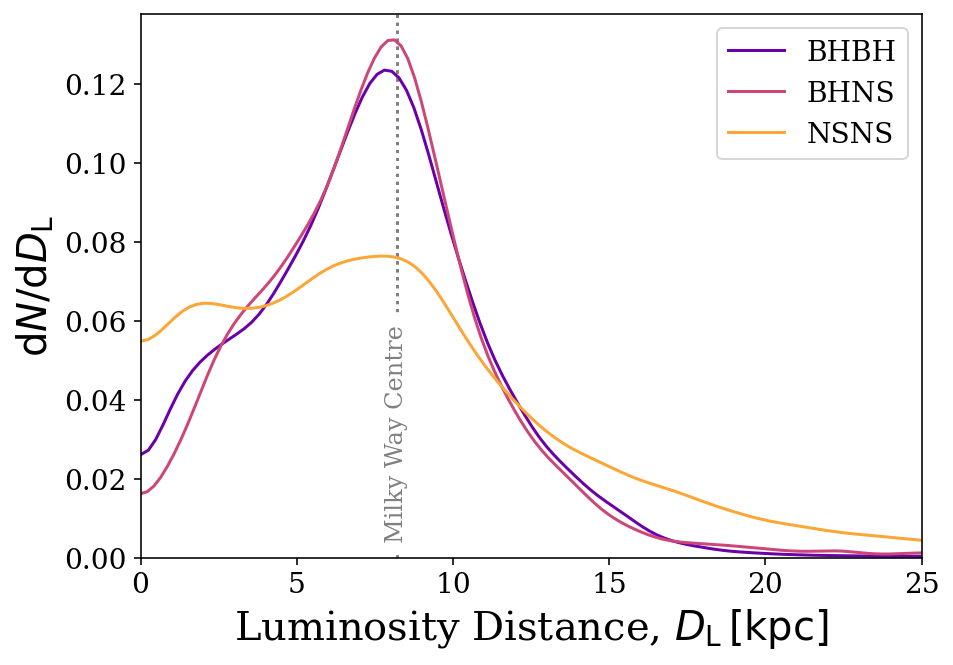

(<Figure size 504x360 with 1 Axes>,
 <AxesSubplot:xlabel='Luminosity Distance, $D_{\\rm L} \\, [\\rm kpc]$', ylabel='$\\mathrm{d}N / \\mathrm{d} D_{\\rm L}$'>)

In [164]:
distance_distribution(bootstraps=None, save_fig=False)

Plotting distance for BHBH
Plotting distance for BHNS
Plotting distance for NSNS

Plot complete, it took 145.3 seconds


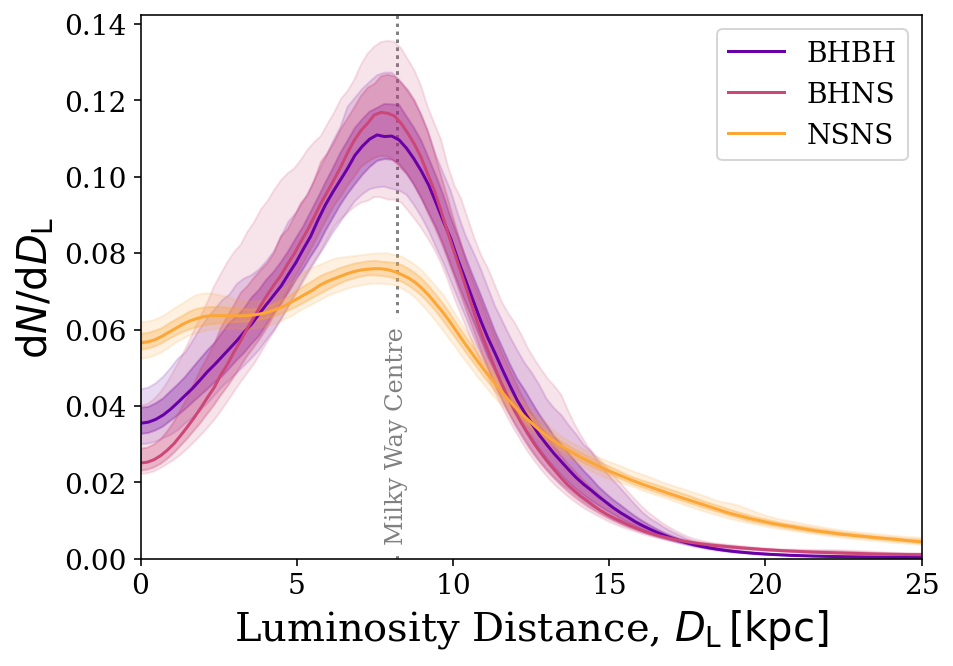

(<Figure size 504x360 with 1 Axes>,
 <AxesSubplot:xlabel='Luminosity Distance, $D_{\\rm L} \\, [\\rm kpc]$', ylabel='$\\mathrm{d}N / \\mathrm{d} D_{\\rm L}$'>)

In [165]:
distance_distribution()

In [118]:
t_merge_left_all = {
    "BHBH": None,
    "BHNS": None,
    "NSNS": None
}

for dco_type in dco_types:

    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, "fiducial"), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] > 7
        data = full_data[snr_mask]
        
        print(dco_type)

        t_merge = legwork.evol.get_t_merge_ecc(ecc_i=data["e_DCO"], a_i=data["a_DCO"] * u.AU,
                                               m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun)

        t_merge_left_all[dco_type] = (t_merge.to(u.Gyr) - (data["tau"] - (data["t_evol"] / 1e3)) * u.Gyr).to(u.Myr)
        print("done")
        print()

BHBH
done

BHNS
done

NSNS
done



In [119]:
""" helper function for setting log spaced ticks """
def get_log_ticks(min_log, max_log):
    
    bottom = np.floor(min_log).astype(int)
    top = np.ceil(max_log).astype(int)
    
    ticks = []
    
    for i in range(bottom, top + 1):
        for j in range(2, 10):
            log_tick = np.log10(j * 10**(i))
            if log_tick > bottom and log_tick < top:
                ticks.append(log_tick)
                
    return ticks

In [120]:
def detectable_properties_grid(model=0, t_obs=4 * u.yr, bootstraps=200, dco_types=dco_types,
                               colours=dco_colours, save_fig=True, file_name=None,
                               fig=None, axes=None, show=True,
                               lower_mass_gap=False, eccentricity_labels=False, legend=True):

    start = time.time()

    detection_total = detections_4yr if t_obs == 4 * u.yr else detections_10yr
    
    if fig is None or axes is None:
        fig, axes = plt.subplots(2, 3, figsize=(22, 10))
    plt.subplots_adjust(top=0.96, hspace=0.25, wspace=0.22)
    lw = 4
    
    # loop over each DCO type
    for i, dco_type in enumerate(dco_types):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

            data = full_data[snr_mask]
        
        # convert separation to frequency
        f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                    a=data["a_LISA"] * u.AU)
        print(variations[model]["med"], dco_type, len(data["m_1"]))
        
        q = data["m_2"] / data["m_1"]
        q[q > 1] = 1 / q[q > 1]

        # work out which masses are the BH and NS masses
        if dco_type == "BHNS":
            mBH = np.maximum(data["m_1"], data["m_2"])
            mNS = np.minimum(data["m_1"], data["m_2"])
            mass_weights = data["weight"]
            mass_seeds = data["seed"]
        elif dco_type == "BHBH":
            mBH = np.concatenate((data["m_1"], data["m_2"]))
            mass_weights = np.concatenate((data["weight"], data["weight"]))
            mass_seeds = np.concatenate((data["seed"], -1 * data["seed"]))
        elif dco_type == "NSNS":
            mNS = np.concatenate((data["m_1"], data["m_2"]))
            mass_weights = np.concatenate((data["weight"], data["weight"]))
            mass_seeds = np.concatenate((data["seed"], -1 * data["seed"]))
        
        # plot the orbital frequency distribution
        print("\t Plotting orbital frequency")
        if bootstraps is not None:
            axes[0, 0] = boots.bootstrapped_kde(np.log10(f_orb_LISA.value), data["weight"], data["seed"],
                                                ax=axes[0, 0], color=colours[dco_type], label=dco_type,
                                                bootstraps=bootstraps)
        else:
            axes[0, 0].plot(*boots.kde(np.log10(f_orb_LISA.value), weights=data["weight"]), color=colours[dco_type], label=dco_type)
        axes[0, 0].set_xlabel(r"Orbital Frequency, $f_{\rm orb, LISA} \, [\rm Hz]$")
        axes[0, 0].set_xlim(-5.1, -2.1)
        
        axes[0, 0].set_xticks([-5, -4, -3, -2])
        axes[0, 0].set_xticklabels([r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$"])
        axes[0, 0].xaxis.set_minor_locator(FixedLocator(get_log_ticks(*axes[0, 0].get_xlim())))
        
        axes[0, 0].set_ylabel(r"$\mathrm{d}N / \mathrm{d}(\log_{10} (f_{\rm orb}))$")
        
        # plot the BH mass distribution
        print("\t Plotting black hole mass")
        if dco_type in ["BHNS", "BHBH"]:
            if bootstraps is not None:
                axes[0, 1] = boots.bootstrapped_kde(mBH, mass_weights, mass_seeds, bw_adjust=1.4,
                                                    ax=axes[0, 1], color=colours[dco_type], label=dco_type,
                                                    bootstraps=bootstraps, lower_bound=0.0, x_min=2.5, x_max=21)
            else:
                axes[0, 1].plot(*boots.kde(mBH, weights=mass_weights, lower_bound=0.0, bw_adjust=1.4, x_min=2.5),
                                color=colours[dco_type], label=dco_type)
            
            if model == 8:
                min_mass = np.min(mBH)
                axes[0, 1].plot([min_mass, min_mass], [0, 0.065], color=colours[dco_type])
            
            axes[0, 1].set_xlabel(r"Black Hole Mass, $m_{\rm BH} \, [\rm M_{\odot}]$")
            axes[0, 1].set_xlim(2.5, 21)
                
            axes[0, 1].set_ylabel(r"$\mathrm{d}N / \mathrm{d} m_{\rm BH}$")
            
            if dco_type == "BHBH":
                ax_right = axes[0, 1].twinx()
                
                ax_right.plot(*boots.kde(data["m_1"], weights=data["weight"], lower_bound=0.0, bw_adjust=1.4, x_min=2.5),
                              color=colours[dco_type], label=dco_type, linestyle="dotted")
                ax_right.plot(*boots.kde(data["m_2"], weights=data["weight"], lower_bound=0.0, bw_adjust=1.4, x_min=2.5),
                              color=colours[dco_type], label=dco_type, linestyle="dotted")
                
                ax_right.set_ylim(0, axes[0, 1].get_ylim()[-1] * 4)
                ax_right.set_yticks([])
                ax_right.set_ylabel("")
        
        print("\t Plotting mass ratio")            
        if bootstraps is not None:
            axes[0, 2] = boots.bootstrapped_kde(q, data["weight"], data["seed"], bootstraps=bootstraps,
                                                ax=axes[0, 2], color=colours[dco_type], label=dco_type,
                                                x_min=0.0, x_max=1.0, lower_bound=0.0, upper_bound=1.0)
        else:
            axes[0, 2].plot(*boots.kde(q, weights=data["weight"], lower_bound=0.0, upper_bound=1.0),
                            color=colours[dco_type], label=dco_type)
        axes[0, 2].set_xlim(0, 1)
        axes[0, 2].set_ylim(0, 10)
        axes[0, 2].set_xlabel(r"Mass Ratio, $q \equiv m_{2} / m_{1}$")
        axes[0, 2].set_ylabel(r"$\mathrm{d}N / \mathrm{d}q$")
        
        if dco_type == "BHNS":
            axes[0, 2].annotate("At least 1 CE", xytext=(0.18, 8), xy=(0.18, 4), va="center", ha="center",
                                rotation=90, fontsize=0.6*fs, color=dco_colours[dco_type],
                                arrowprops=dict(arrowstyle="->", color=dco_colours[dco_type]))
            axes[0, 2].annotate("Only stable MT", xytext=(0.33, 8), xy=(0.33, 4.5), va="center", ha="center",
                                rotation=90, fontsize=0.6*fs, color=dco_colours[dco_type],
                                arrowprops=dict(arrowstyle="->", color=dco_colours[dco_type]))
            
        if dco_type == "NSNS":
            axes[0, 2].annotate("Extends above axis", xy=(0.92, 9.8), xytext=(0.92, 5.5), ha="center",
                                va="center", rotation=90, color=dco_colours[dco_type], fontsize=0.6*fs,
                                arrowprops=dict(arrowstyle="->", color=dco_colours[dco_type]))
            
        # plot the eccentricity distribution
        print("\t Plotting eccentricity")
        if bootstraps is not None:
            axes[1, 0] = boots.bootstrapped_kde(np.log10(data["e_LISA"]), data["weight"], data["seed"],
                                                ax=axes[1, 0], color=colours[dco_type], label=dco_type,
                                                bw_adjust=1.5, bootstraps=bootstraps, upper_bound=0.0)
        else:
            axes[1, 0].plot(*boots.kde(np.log10(data["e_LISA"]), weights=data["weight"], upper_bound=0.0, bw_adjust=1.5),
                            color=colours[dco_type], label=dco_type)
            
        axes[1, 0].set_xlabel(r"Eccentricity, $e_{\rm LISA}$")
        axes[1, 0].set_xlim(-4.1, 0)
        axes[1, 0].set_xticks([-4, -3, -2, -1, 0])
        axes[1, 0].set_xticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", "1"])
        axes[1, 0].xaxis.set_minor_locator(FixedLocator(get_log_ticks(*axes[1, 0].get_xlim())))
        axes[1, 0].set_ylabel(r"$\mathrm{d}N / \mathrm{d}(\log_{10} (e_{\rm LISA}))$")
        
        # plot the lookback time
        print("\t Plotting lookback time")
        if bootstraps is not None:
            axes[1, 1] = boots.bootstrapped_kde(data["tau"], data["weight"], data["seed"],
                                          ax=axes[1, 1], color=colours[dco_type], label=dco_type,
                                          bootstraps=bootstraps, lower_bound=0.0, bw_adjust=1.5)
        else:
            axes[1, 1].plot(*boots.kde(data["tau"], weights=data["weight"], lower_bound=0.0, bw_adjust=1.5),
                            color=colours[dco_type], label=dco_type)
            
        axes[1, 1].set_xlabel(r"Time since formation, $\tau \, [\rm Gyr]$")
        axes[1, 1].set_xlim(0, 12)
        axes[1, 1].set_ylabel(r"$\mathrm{d}N / \mathrm{d}\tau$")

        print("\t Plotting merger time remaining")
        if bootstraps is not None:
            axes[1, 2] = boots.bootstrapped_kde(np.log10(t_merge_left_all[dco_type].to(u.yr).value),
                                          data["weight"], data["seed"],
                                          ax=axes[1, 2], color=colours[dco_type], label=dco_type,
                                          bootstraps=bootstraps, x_min=3.5, x_max=8.3)
        else:
            axes[1, 2].plot(*boots.kde(np.log10(t_merge_left_all[dco_type].to(u.yr).value), weights=data["weight"]),
                            color=colours[dco_type], label=dco_type)
            
        axes[1, 2].set_xlabel(r"Time until merger, $t_{\rm merge} \, [\rm yr]$")
        axes[1, 2].set_xlim(3.5, 8.3)
        axes[1, 2].set_xticks([4, 5, 6, 7, 8])
        axes[1, 2].set_xticklabels([r"$10^{4}$", r"$10^{5}$", r"$10^{6}$", r"$10^{7}$", r"$10^{8}$"])
        axes[1, 2].xaxis.set_minor_locator(FixedLocator(get_log_ticks(*axes[1, 2].get_xlim())))
        axes[1, 2].set_ylabel(r"$\mathrm{d}N / \mathrm{d}(\log_{10} (t_{\rm merge}))$")

        
    if lower_mass_gap:
        axes[0, 1].axvspan(2.5, 5.0, color="grey", alpha=0.25)
        axes[0, 1].annotate("Lower mass gap", xy=(3.75, 0.01), color="grey", rotation=90, ha="center", fontsize=0.6*fs)
        
    if eccentricity_labels:
        for e in [0.01, 0.3]:
            axes[1, 0].axvline(np.log10(e), color="grey", linestyle="dotted")
            axes[1, 0].annotate(r"$e = {{{}}}$".format(e), xy=(np.log10(e), 0.04 if e < 0.1 else 0.4), color="grey",
                                bbox=dict(boxstyle="round", ec="white", fc="white"), ha="center", rotation=90, fontsize=0.7*fs)
    
    if legend:
        handles, labels = axes[0, 0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', fontsize=fs, ncol=3, borderaxespad=0.0)

    for ax in axes.flatten():
        ax.tick_params(labelsize=0.7*fs)
        ax.xaxis.label.set_fontsize(fs)
        
        if ax.get_yscale() == "linear":
            ax.set_ylim(bottom=0.0)

    if save_fig:
        if file_name is not None:
            plt.savefig("../../paper/figures/" + file_name, format="pdf", bbox_inches="tight")
        elif t_obs == 4 * u.yr:
            plt.savefig("../../paper/figures/detectable_properties_4yr.pdf", format="pdf", bbox_inches="tight")
        else:
            plt.savefig("../../paper/figures/detectable_properties_10yr.pdf", format="pdf", bbox_inches="tight")
        
    print()
    print("Plot complete, it took {:1.1f} seconds".format(time.time() - start))

    if show:
        plt.show()
        
    plt.ioff()
    
    return fig, axes

fiducial BHBH 46620
	 Plotting orbital frequency
	 Plotting black hole mass
	 Plotting mass ratio
	 Plotting eccentricity
	 Plotting lookback time
	 Plotting merger time remaining
fiducial BHNS 45166
	 Plotting orbital frequency
	 Plotting black hole mass
	 Plotting mass ratio
	 Plotting eccentricity
	 Plotting lookback time
	 Plotting merger time remaining
fiducial NSNS 33170
	 Plotting orbital frequency
	 Plotting black hole mass
	 Plotting mass ratio
	 Plotting eccentricity
	 Plotting lookback time
	 Plotting merger time remaining

Plot complete, it took 577.7 seconds


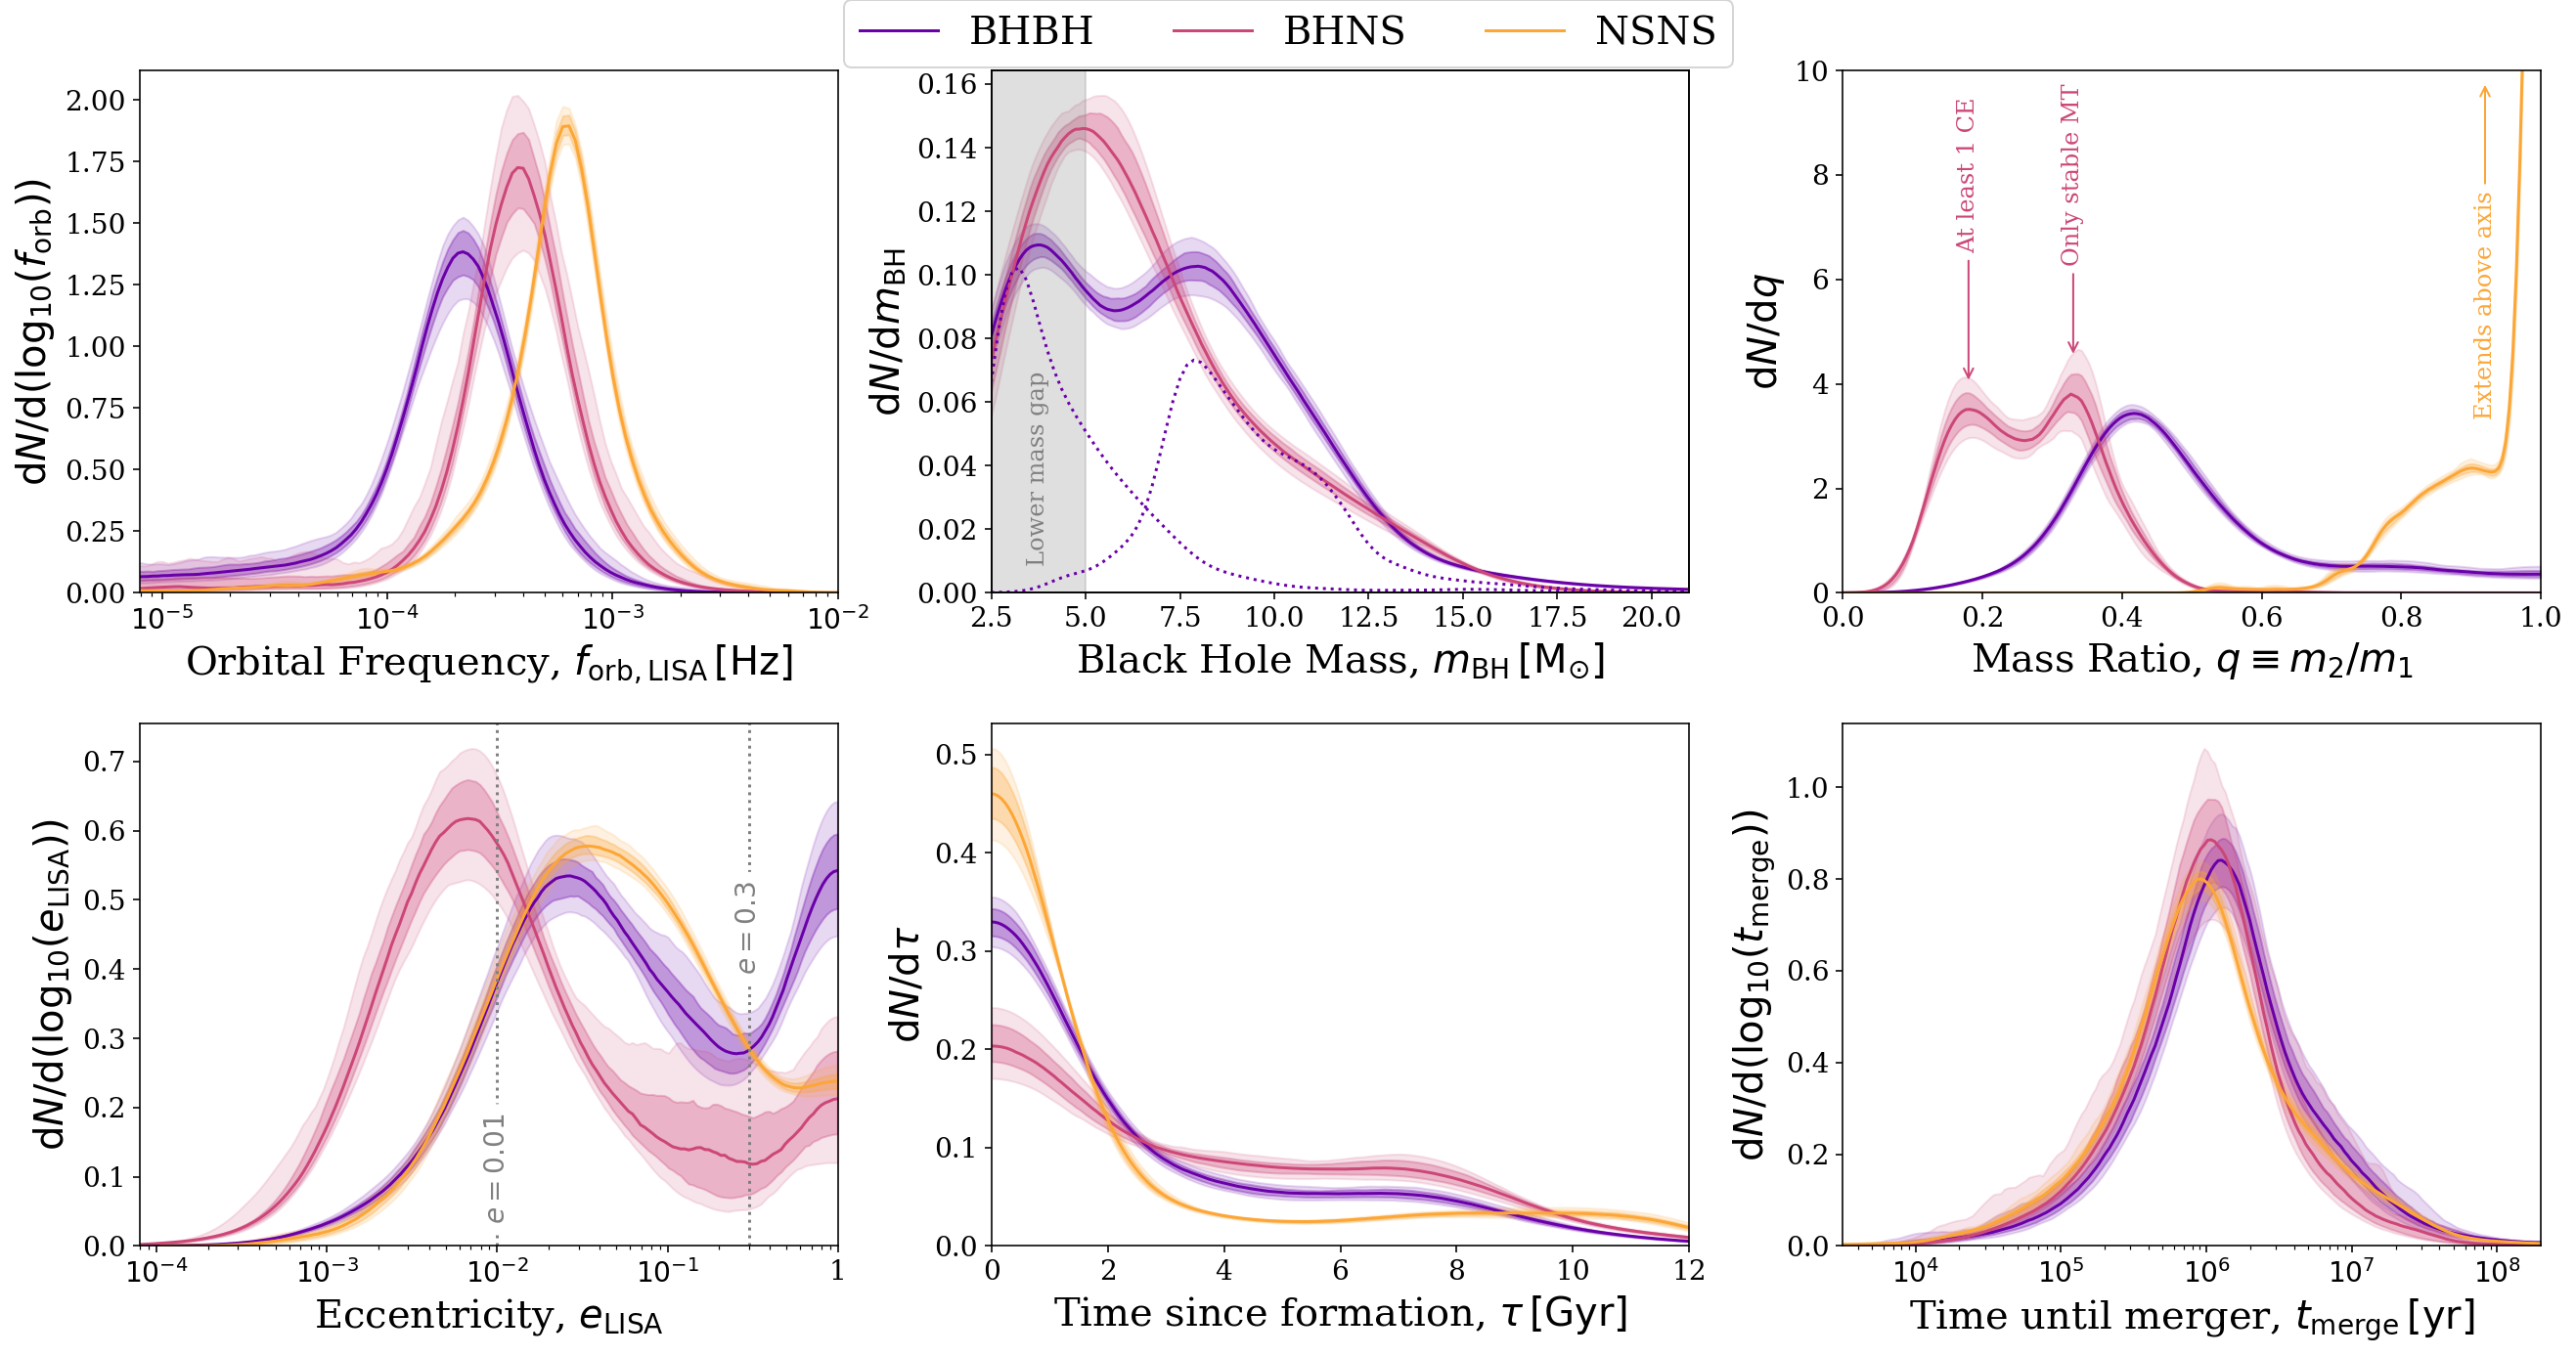

(<Figure size 1584x720 with 7 Axes>,
 array([[<AxesSubplot:xlabel='Orbital Frequency, $f_{\\rm orb, LISA} \\, [\\rm Hz]$', ylabel='$\\mathrm{d}N / \\mathrm{d}(\\log_{10} (f_{\\rm orb}))$'>,
         <AxesSubplot:xlabel='Black Hole Mass, $m_{\\rm BH} \\, [\\rm M_{\\odot}]$', ylabel='$\\mathrm{d}N / \\mathrm{d} m_{\\rm BH}$'>,
         <AxesSubplot:xlabel='Mass Ratio, $q \\equiv m_{2} / m_{1}$', ylabel='$\\mathrm{d}N / \\mathrm{d}q$'>],
        [<AxesSubplot:xlabel='Eccentricity, $e_{\\rm LISA}$', ylabel='$\\mathrm{d}N / \\mathrm{d}(\\log_{10} (e_{\\rm LISA}))$'>,
         <AxesSubplot:xlabel='Time since formation, $\\tau \\, [\\rm Gyr]$', ylabel='$\\mathrm{d}N / \\mathrm{d}\\tau$'>,
         <AxesSubplot:xlabel='Time until merger, $t_{\\rm merge} \\, [\\rm yr]$', ylabel='$\\mathrm{d}N / \\mathrm{d}(\\log_{10} (t_{\\rm merge}))$'>]],
       dtype=object))

In [121]:
detectable_properties_grid(lower_mass_gap=True, eccentricity_labels=True)

fiducial BHBH 46424
	 Plotting orbital frequency
	 Plotting black hole mass
	 Plotting mass ratio
	 Plotting eccentricity
	 Plotting lookback time
	 Plotting merger time remaining
fiducial BHNS 44927
	 Plotting orbital frequency
	 Plotting black hole mass
	 Plotting mass ratio
	 Plotting eccentricity
	 Plotting lookback time
	 Plotting merger time remaining
fiducial NSNS 32805
	 Plotting orbital frequency
	 Plotting black hole mass
	 Plotting mass ratio
	 Plotting eccentricity
	 Plotting lookback time
	 Plotting merger time remaining

Plot complete, it took 576.2 seconds


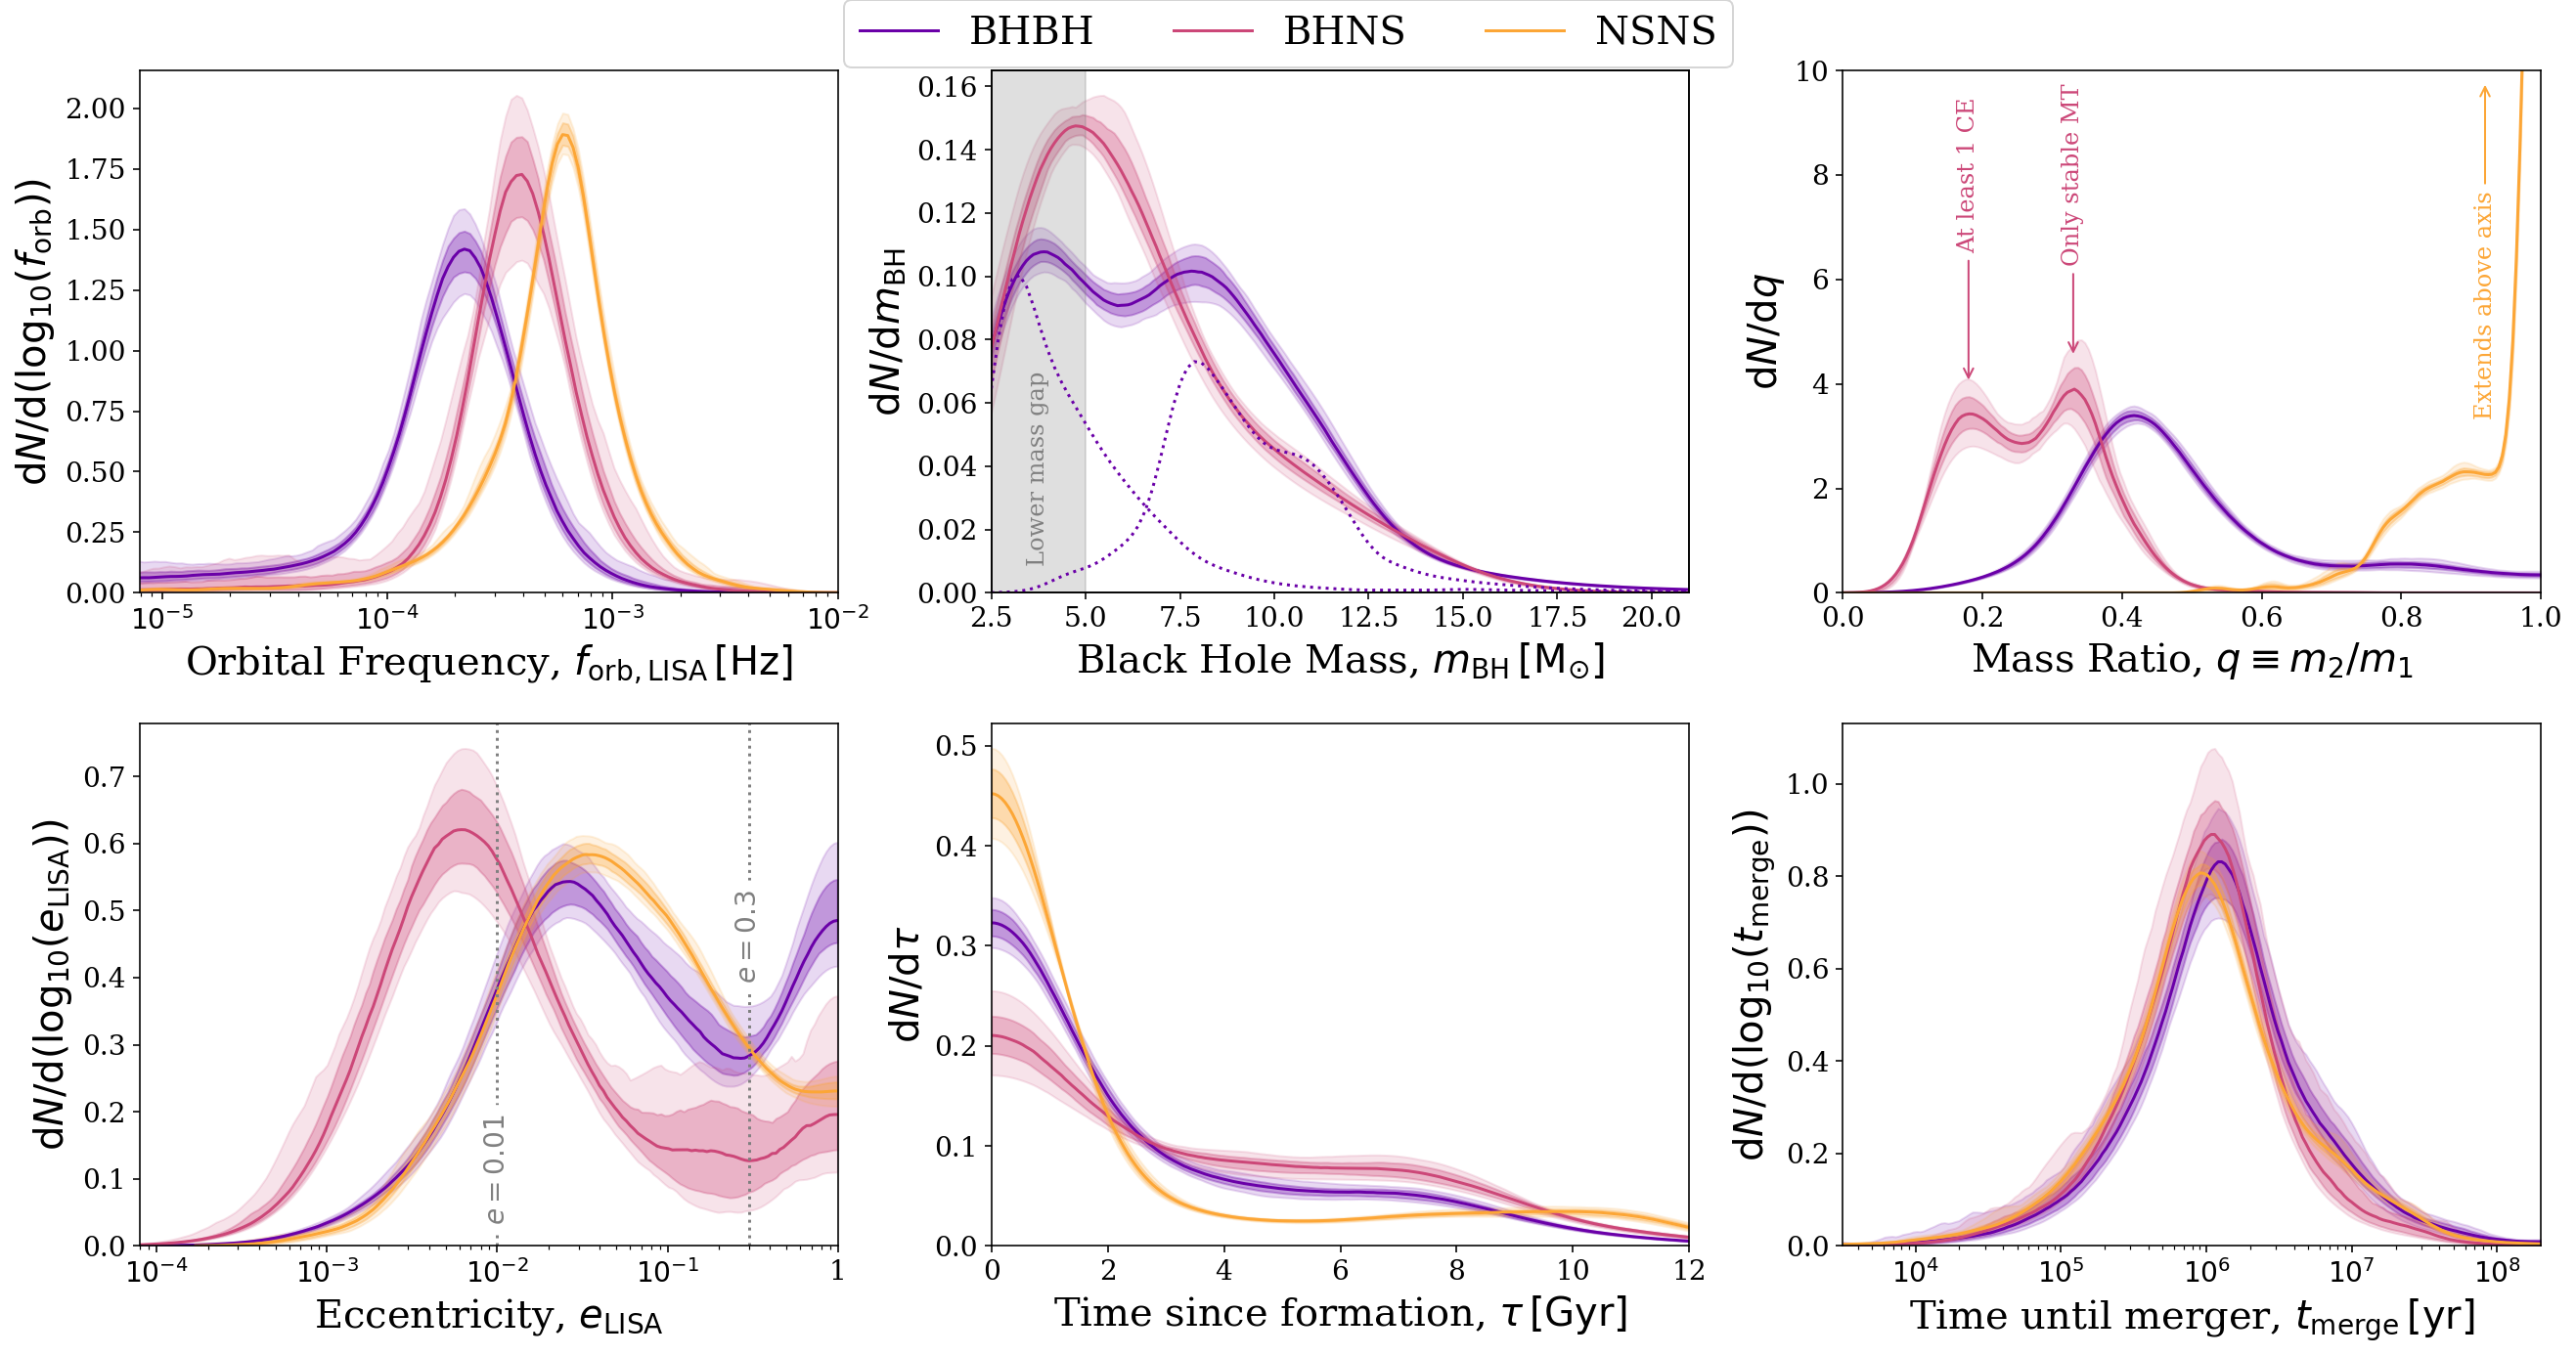

(<Figure size 1584x720 with 7 Axes>,
 array([[<AxesSubplot:xlabel='Orbital Frequency, $f_{\\rm orb, LISA} \\, [\\rm Hz]$', ylabel='$\\mathrm{d}N / \\mathrm{d}(\\log_{10} (f_{\\rm orb}))$'>,
         <AxesSubplot:xlabel='Black Hole Mass, $m_{\\rm BH} \\, [\\rm M_{\\odot}]$', ylabel='$\\mathrm{d}N / \\mathrm{d} m_{\\rm BH}$'>,
         <AxesSubplot:xlabel='Mass Ratio, $q \\equiv m_{2} / m_{1}$', ylabel='$\\mathrm{d}N / \\mathrm{d}q$'>],
        [<AxesSubplot:xlabel='Eccentricity, $e_{\\rm LISA}$', ylabel='$\\mathrm{d}N / \\mathrm{d}(\\log_{10} (e_{\\rm LISA}))$'>,
         <AxesSubplot:xlabel='Time since formation, $\\tau \\, [\\rm Gyr]$', ylabel='$\\mathrm{d}N / \\mathrm{d}\\tau$'>,
         <AxesSubplot:xlabel='Time until merger, $t_{\\rm merge} \\, [\\rm yr]$', ylabel='$\\mathrm{d}N / \\mathrm{d}(\\log_{10} (t_{\\rm merge}))$'>]],
       dtype=object))

In [108]:
detectable_properties_grid(lower_mass_gap=True, eccentricity_labels=True)

fiducial BHBH 46424
	 Plotting orbital frequency
	 Plotting black hole mass
	 Plotting mass ratio
	 Plotting eccentricity
	 Plotting lookback time
	 Plotting merger time remaining
fiducial BHNS 44927
	 Plotting orbital frequency
	 Plotting black hole mass
	 Plotting mass ratio
	 Plotting eccentricity
	 Plotting lookback time
	 Plotting merger time remaining
fiducial NSNS 32805
	 Plotting orbital frequency
	 Plotting black hole mass
	 Plotting mass ratio
	 Plotting eccentricity
	 Plotting lookback time
	 Plotting merger time remaining

Plot complete, it took 3.2 seconds


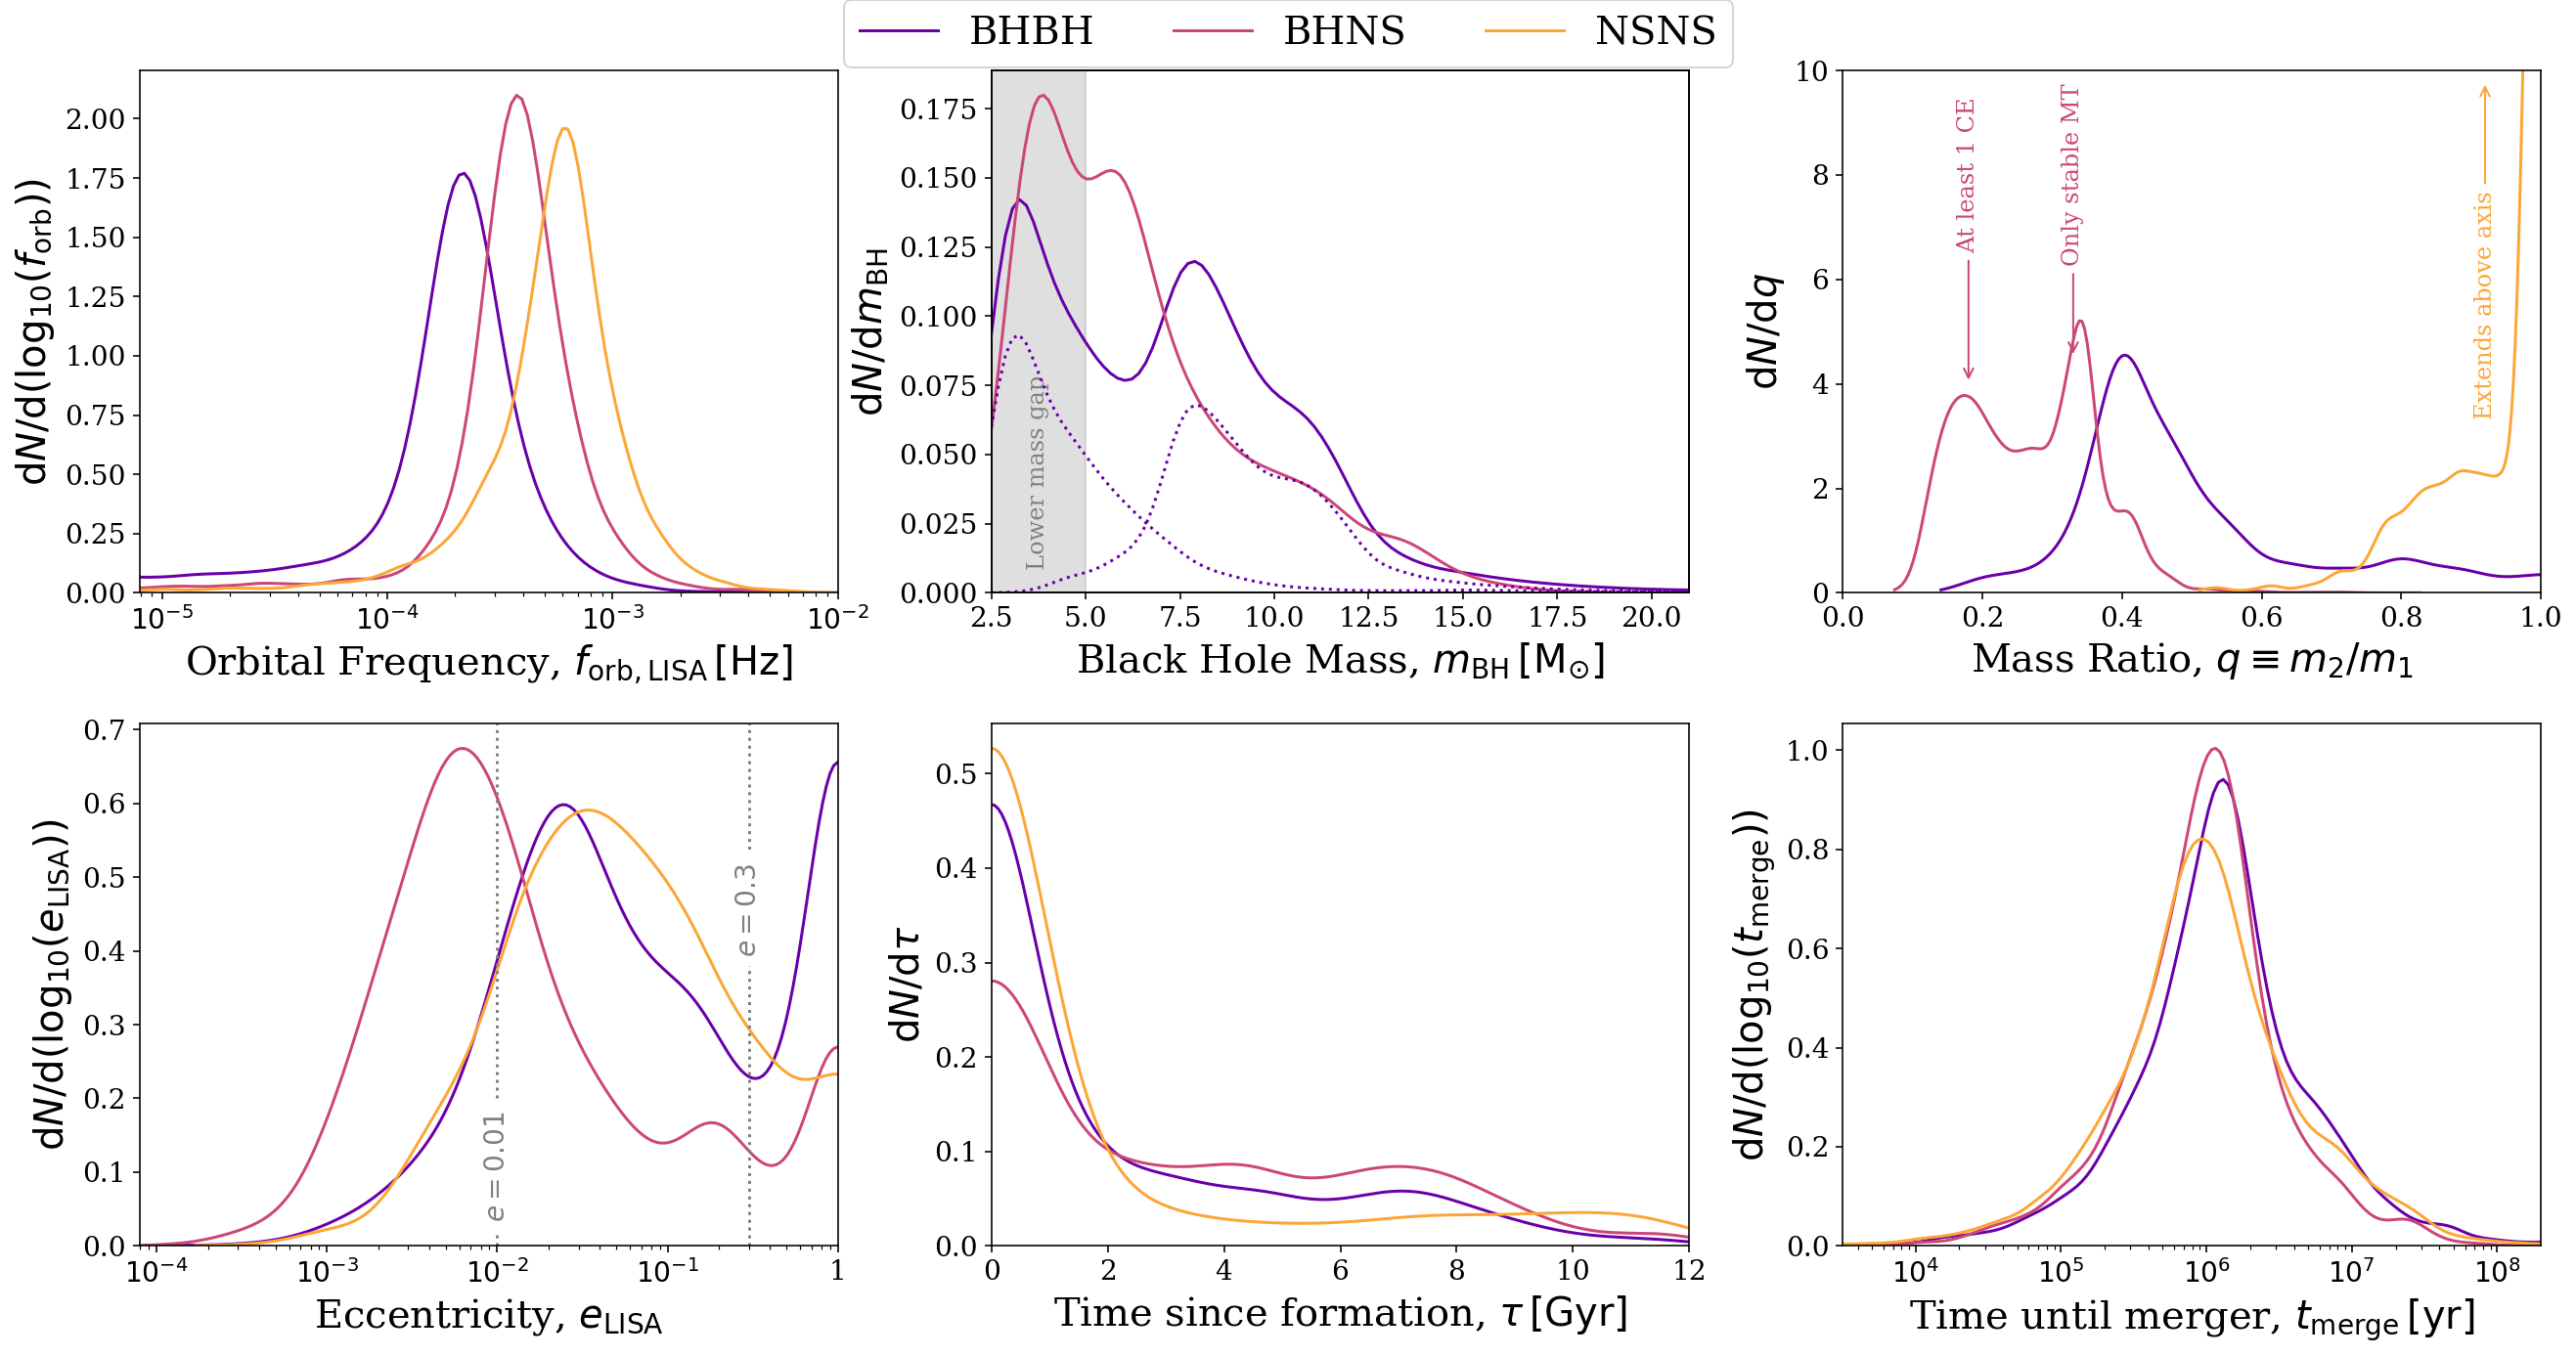

(<Figure size 1584x720 with 7 Axes>,
 array([[<AxesSubplot:xlabel='Orbital Frequency, $f_{\\rm orb, LISA} \\, [\\rm Hz]$', ylabel='$\\mathrm{d}N / \\mathrm{d}(\\log_{10} (f_{\\rm orb}))$'>,
         <AxesSubplot:xlabel='Black Hole Mass, $m_{\\rm BH} \\, [\\rm M_{\\odot}]$', ylabel='$\\mathrm{d}N / \\mathrm{d} m_{\\rm BH}$'>,
         <AxesSubplot:xlabel='Mass Ratio, $q \\equiv m_{2} / m_{1}$', ylabel='$\\mathrm{d}N / \\mathrm{d}q$'>],
        [<AxesSubplot:xlabel='Eccentricity, $e_{\\rm LISA}$', ylabel='$\\mathrm{d}N / \\mathrm{d}(\\log_{10} (e_{\\rm LISA}))$'>,
         <AxesSubplot:xlabel='Time since formation, $\\tau \\, [\\rm Gyr]$', ylabel='$\\mathrm{d}N / \\mathrm{d}\\tau$'>,
         <AxesSubplot:xlabel='Time until merger, $t_{\\rm merge} \\, [\\rm yr]$', ylabel='$\\mathrm{d}N / \\mathrm{d}(\\log_{10} (t_{\\rm merge}))$'>]],
       dtype=object))

In [106]:
detectable_properties_grid(lower_mass_gap=True, eccentricity_labels=True, bootstraps=None, save_fig=False)

In [132]:
detections_4yr[:, 0].mean(axis=1).round()

array([108.,  62.,  12.])

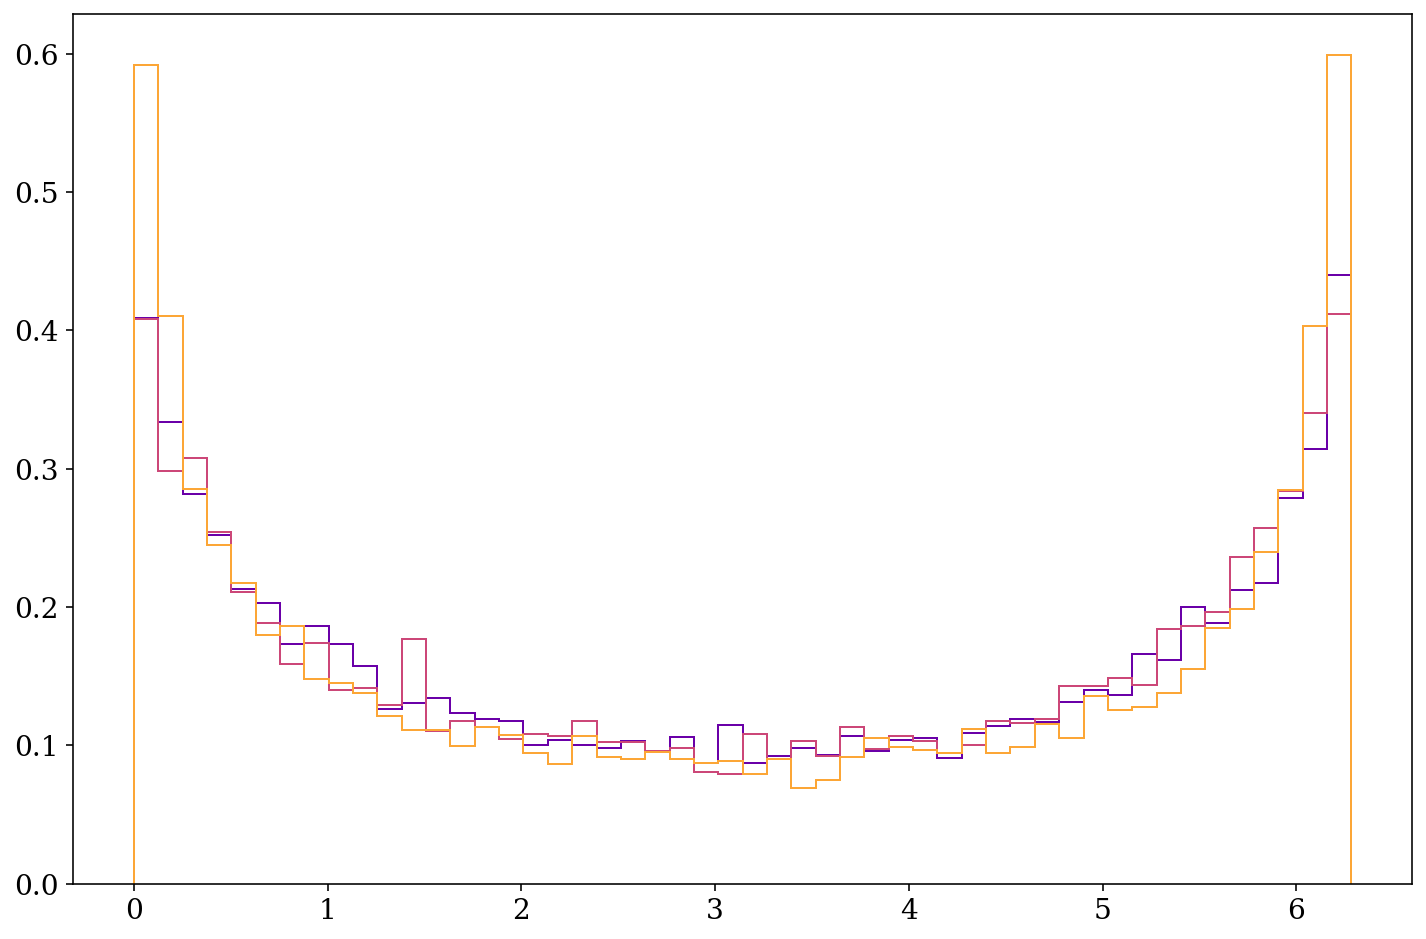

In [127]:
# loop over each DCO type
for i, dco_type in enumerate(dco_types):
    # open corresponding COMPAS file
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[0]["file"]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] > 7

        data = full_data[snr_mask]
        
    plt.hist(data["theta"], weights=data["weight"], bins=50, color=dco_colours[dco_type], alpha=1, density=True, histtype="step")
    
# plt.yscale("log")
# plt.ylim(1e-2, 2.5e0)

plt.show()

## Measurement uncertainties

In [6]:
detectable_harmonics, snr_uncertainty, ecc_uncertainty, max_harmonics = unc.get_ecc_uncertainty(harmonic_threshold=3, model=variations[0]["file"], t_obs=4*u.yr)

In [22]:
def chirp_mass_uncertainty(model=0, t_obs=4 * u.yr, bootstraps=200, dco_types=dco_types,
                           colours=dco_colours, save_fig=True, file_name=None):
    detection_total = detections_4yr if t_obs == 4 * u.yr else detections_10yr
    
    fig, ax = plt.subplots(figsize=(7, 5))
    lw = 4
    
    # loop over each DCO type
    for i, dco_type in enumerate(dco_types):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

            data = full_data[snr_mask]
            
        detection_total = detections_4yr if t_obs == 4 * u.yr else detections_10yr
        
        f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                    a=data["a_LISA"] * u.AU)

        m_c = legwork.utils.chirp_mass(data["m_1"], data["m_2"]) * u.Msun
        f_orb_dot = legwork.utils.fn_dot(m_c=m_c, f_orb=f_orb_LISA, e=data["e_LISA"], n=1)
        sigma_theta = unc.sky_localisation(data["snr"], f_orb_LISA * max_harmonics[dco_type]).to(u.deg)
    
        D_Mc = unc.get_m_c_uncertainty(f_orb_LISA * max_harmonics[dco_type], f_orb_dot * max_harmonics[dco_type],
                                   data["e_LISA"], ecc_uncertainty[dco_type], data["snr"], t_obs).decompose()
        
        print(variations[model]["med"], dco_type, len(data["m_1"]))
        
        if bootstraps is not None:
            ax = boots.bootstrapped_ecdf(D_Mc.value, weights=data["weight"], seeds=data["seed"], normalisation=1, ax=ax,
                                   log_scale=(True, False), color=colours[dco_type],
                                   label=dco_type, bootstraps=bootstraps)
            ax.set_xlim(9e-5, 2e3)
            ax.axvspan(1.0, ax.get_xlim()[1], color="grey", zorder=10, alpha=0.2)
        else:
            sns.ecdfplot(x=np.log10(D_Mc.value), weights=data["weight"], ax=ax, log_scale=(False, False),
                         color=colours[dco_type], label=dco_type)
            ax.set_xlim(np.log10(9e-5), np.log10(2e3))
            ax.axvspan(0, ax.get_xlim()[1], color="grey", zorder=10, alpha=0.2)
        
        ax.set_xlabel(r"Chirp Mass Error, $\Delta \mathcal{M}_c / \mathcal{M}_c$")
        
    ax.legend(fontsize=0.7*fs)

    ax.tick_params(labelsize=0.7*fs)
    ax.xaxis.label.set_fontsize(fs)

    ax.set_ylim(0, 1)
        
    ax.set_ylabel("CDF")

    if save_fig:
        if file_name is not None:
            plt.savefig(file_name, format="pdf", bbox_inches="tight")
        elif t_obs == 4 * u.yr:
            plt.savefig("../figures/chirp_mass_uncertainty_4yr.pdf", format="pdf", bbox_inches="tight")
        else:
            plt.savefig("../figures/chirp_mass_uncertainty_10yr.pdf", format="pdf", bbox_inches="tight")

    plt.show()

fiducial BHBH 46424
fiducial BHNS 44927
fiducial NSNS 32805


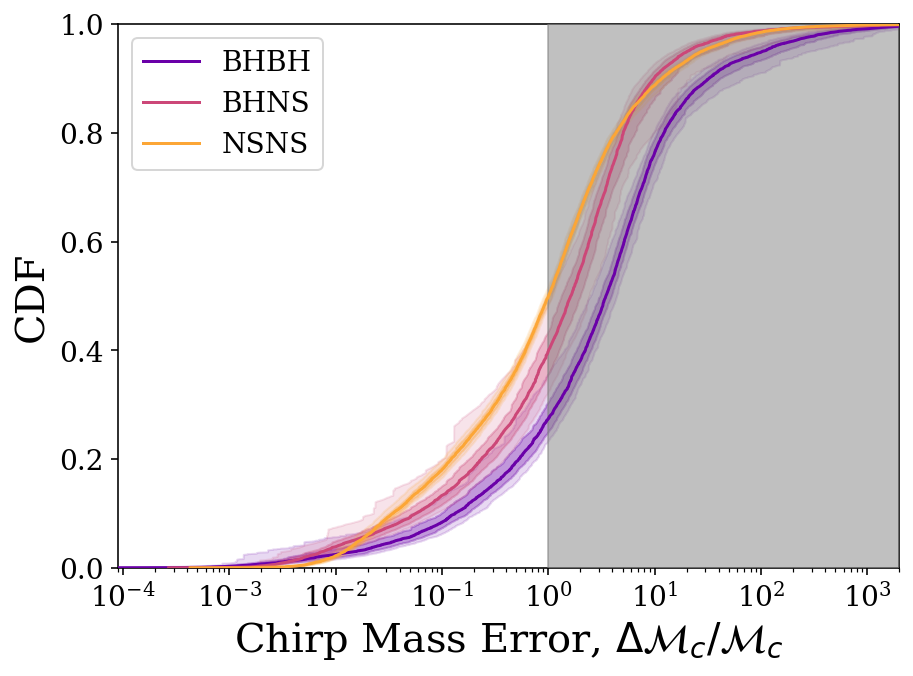

In [23]:
chirp_mass_uncertainty()

In [25]:
def angular_resolution(model=0, t_obs=4 * u.yr, bootstraps=200, dco_types=dco_types,
                       colours=dco_colours, save_fig=True, file_name=None):
    detection_total = detections_4yr if t_obs == 4 * u.yr else detections_10yr
    
    fig, ax = plt.subplots(figsize=(7, 5))
    lw = 4
    
    # loop over each DCO type
    for i, dco_type in enumerate(dco_types):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

            data = full_data[snr_mask]
            
        detection_total = detections_4yr if t_obs == 4 * u.yr else detections_10yr
        
        f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                    a=data["a_LISA"] * u.AU)

        m_c = legwork.utils.chirp_mass(data["m_1"], data["m_2"]) * u.Msun
        sigma_theta = unc.sky_localisation(data["snr"], f_orb_LISA * max_harmonics[dco_type]).to(u.deg)
        
        print(variations[model]["med"], dco_type, len(data["m_1"]))
        
        if bootstraps is not None:
            boots.bootstrapped_ecdf(sigma_theta.value, weights=data["weight"], seeds=data["seed"], normalisation=1, ax=ax,
                              log_scale=(True, False), color=colours[dco_type], label=dco_type)
            ax.set_xlim(5e-3, 5e1)
        else:
            sns.ecdfplot(x=np.log10(sigma_theta.value), weights=data["weight"], ax=ax, log_scale=(False, False),
                         color=colours[dco_type], label=dco_type)
            ax.set_xlim(np.log10(5e-3), np.log10(5e1))
        
        ax.set_xlabel(r"Angular Resolution, $\sigma_{\theta} \ [{\rm deg}]$")
        
    ax.legend(fontsize=0.7*fs)

    ax.tick_params(labelsize=0.7*fs)
    ax.xaxis.label.set_fontsize(fs)

    ax.set_ylim(0, 1)
        
    ax.set_ylabel("CDF")

    if save_fig:
        if file_name is not None:
            plt.savefig(file_name, format="pdf", bbox_inches="tight")
        elif t_obs == 4 * u.yr:
            plt.savefig("../figures/angular_resolution_4yr.pdf", format="pdf", bbox_inches="tight")
        else:
            plt.savefig("../figures/angular_resolution_10yr.pdf", format="pdf", bbox_inches="tight")

    plt.show()

fiducial BHBH 46424
fiducial BHNS 44927
fiducial NSNS 32805


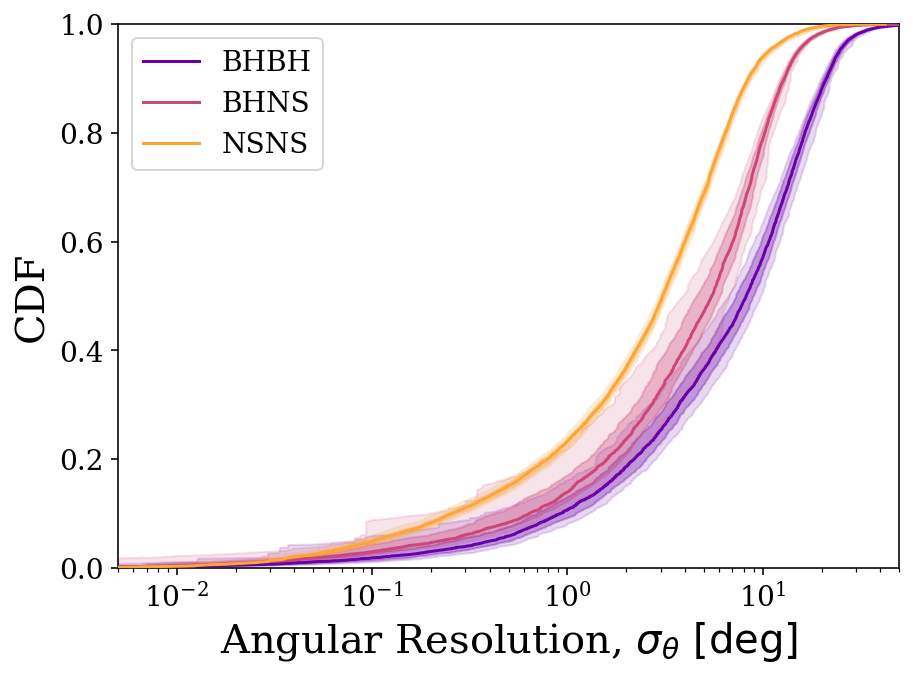

In [26]:
angular_resolution()

# Mass distribution for simple MW

starting BHBH
mBH
starting BHNS
mBH
starting NSNS
mBH


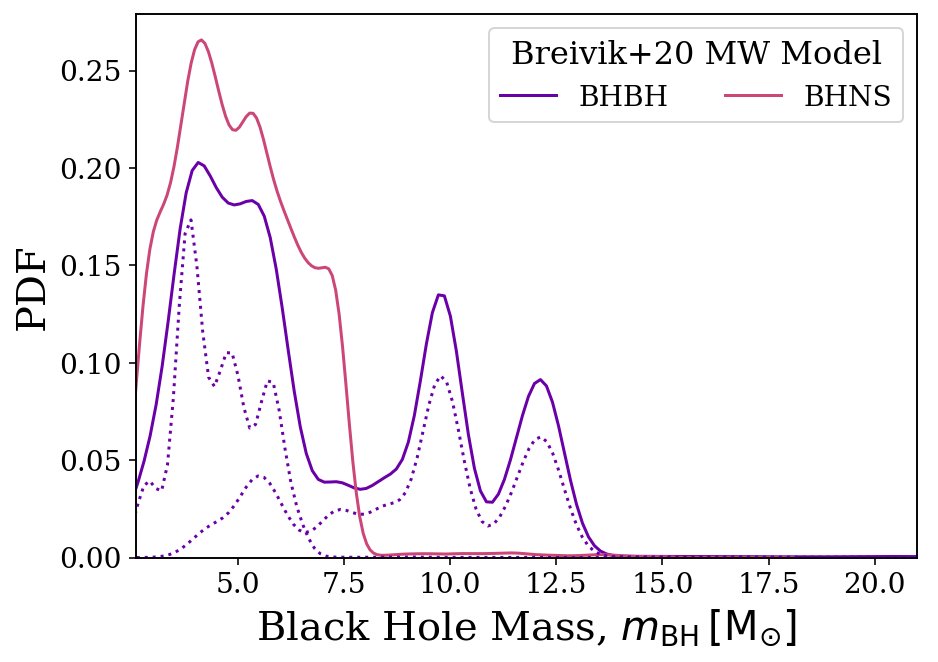

In [166]:
model = 0
t_obs = 4 * u.yr

fig, ax = plt.subplots(figsize=(7, 5))

lw = 4

for i, dco_type in enumerate(["BHBH", "BHNS", "NSNS"]):
    print("starting", dco_type)
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

        data = full_data[snr_mask]

    detection_total = detections_4yr if t_obs == 4 * u.yr else detections_10yr

    m_c = legwork.utils.chirp_mass(data["m_1"], data["m_2"]) * u.Msun
    f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                          a=data["a_LISA"] * u.AU)
    f_orb_dot = legwork.utils.fn_dot(m_c=m_c, f_orb=f_orb_LISA, e=data["e_LISA"], n=1)
    sigma_theta = sky_localisation(data["snr"], f_orb_LISA * max_harmonics[dco_type]).to(u.deg)

    D_Mc = get_m_c_uncertainty(f_orb_LISA * max_harmonics[dco_type], f_orb_dot * max_harmonics[dco_type],
                               data["e_LISA"], ecc_uncertainty[dco_type], data["snr"], t_obs).decompose()

    fake_seeds = np.linspace(0, len(data["seed"]), len(data["seed"]))    

    if dco_type == "BHNS":
        mBH = np.maximum(data["m_1"], data["m_2"])
        mNS = np.minimum(data["m_1"], data["m_2"])
        mass_weights = data["weight"]
        mass_seeds = data["seed"]
    elif dco_type == "BHBH":
        mBH = np.concatenate((data["m_1"], data["m_2"]))
        mass_weights = np.concatenate((data["weight"], data["weight"]))
        mass_seeds = np.concatenate((data["seed"], -1 * data["seed"]))
    elif dco_type == "NSNS":
        mNS = np.concatenate((data["m_1"], data["m_2"]))
        mass_weights = np.concatenate((data["weight"], data["weight"]))
        mass_seeds = np.concatenate((data["seed"], -1 * data["seed"]))

    print("mBH")

    if dco_type in ["BHNS", "BHBH"]:

        sns.kdeplot(mBH, weights=mass_weights, bw_adjust=1.4,
                    ax=ax, color=dco_colours[dco_type], label=dco_type)

        ax.set_xlabel(r"Black Hole Mass, $m_{\rm BH} \, [\rm M_{\odot}]$")
        ax.set_xlim(2.6, 21)

        if dco_type == "BHBH":
            ax_right = ax.twinx()
            sns.kdeplot(data["m_1"], weights=data["weight"], bw_adjust=1.4, ax=ax_right,
                        color=dco_colours[dco_type], label=dco_type, linestyle="dotted")
            sns.kdeplot(data["m_2"], weights=data["weight"], bw_adjust=1.4, ax=ax_right,
                        color=dco_colours[dco_type], label=dco_type, linestyle="dotted")

            ax_right.set_ylim(0, ax.get_ylim()[-1] * 4)
            ax_right.set_yticks([])
            ax_right.set_ylabel("")
            
ax.set_ylabel("PDF")

legend = ax.legend(title="Breivik+20 MW Model", fontsize=0.7*fs, ncol=2)
legend.get_title().set_fontsize(0.8*fs)

plt.savefig("../figures/BH_mass_dist_simple_mw.pdf", format="pdf", bbox_inches="tight")
        
plt.show()

# NSNS distance exploration

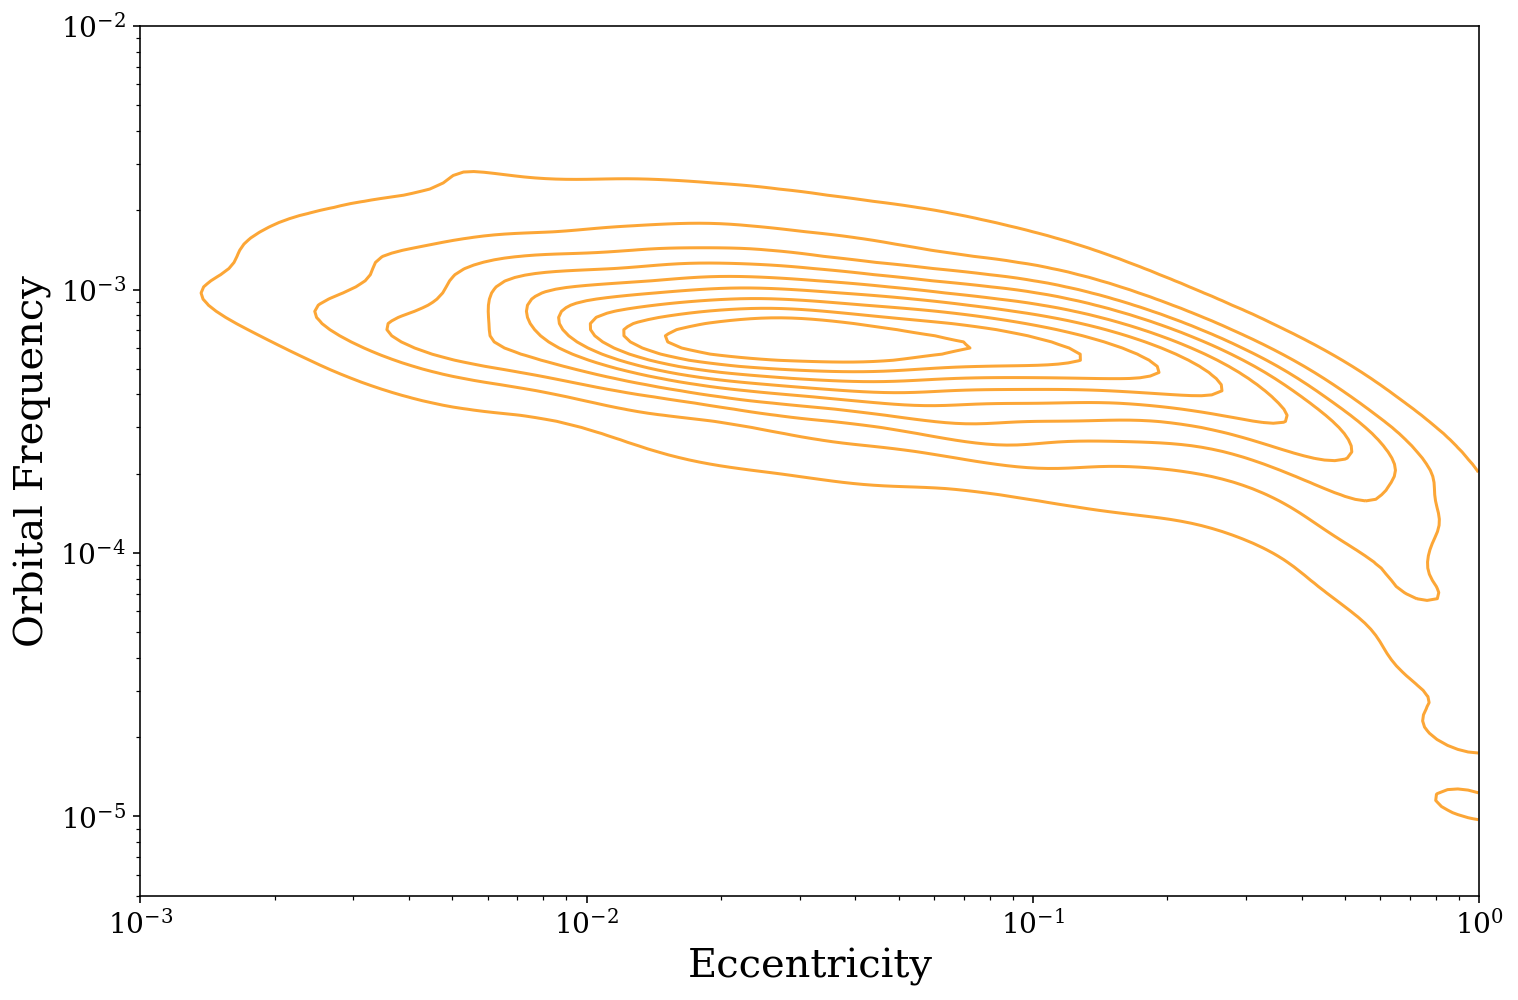

In [6]:
for i, dco_type in enumerate(["NSNS"]):
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, "fiducial"), "r") as f:
        data = f["simulation"][...].squeeze()

    f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                a=data["a_LISA"] * u.AU)
    
#     plt.scatter(data["e_LISA"], f_orb_LISA, s=data["weight"], color=dco_colours[dco_type])
    sns.kdeplot(x=data["e_LISA"], y=f_orb_LISA, weights=data["weight"], color=dco_colours[dco_type], log_scale=(True, True), cut=0)
    
    plt.xscale("log")
    plt.yscale("log")
    
    plt.ylim(5e-6, 1e-2)
    plt.xlim(1e-3, 1e0)
    
    plt.xlabel("Eccentricity")
    plt.ylabel("Orbital Frequency")

    plt.show()

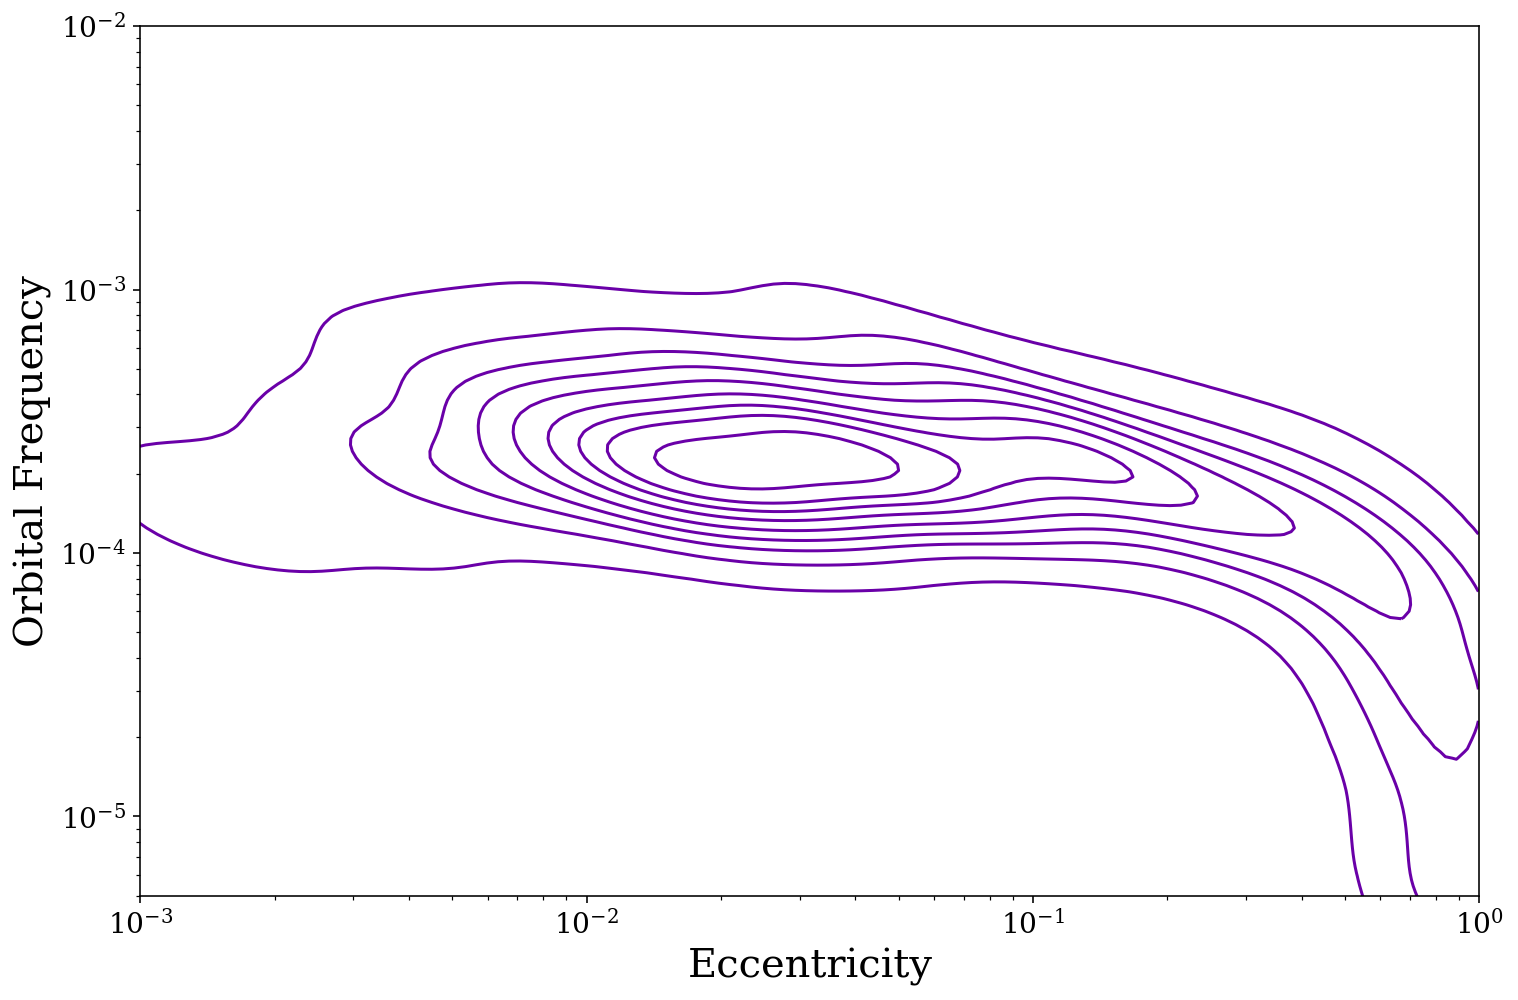

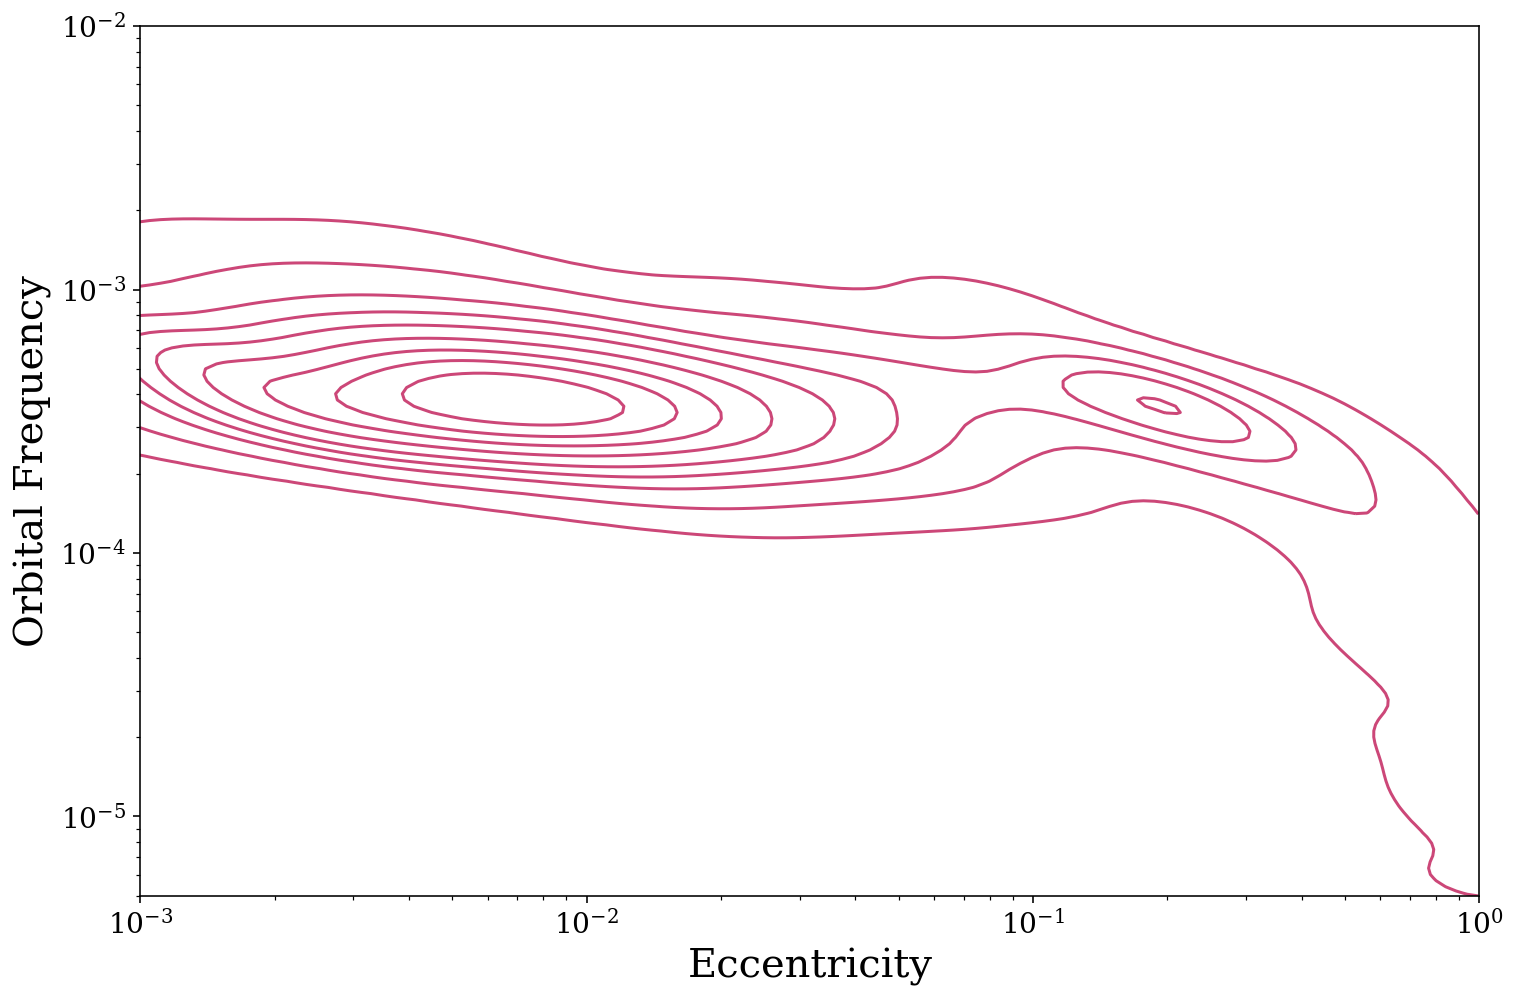

In [7]:
for i, dco_type in enumerate(["BHBH", "BHNS"]):
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, "fiducial"), "r") as f:
        data = f["simulation"][...].squeeze()

    f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                a=data["a_LISA"] * u.AU)
    
#     plt.scatter(data["e_LISA"], f_orb_LISA, s=data["weight"], color=dco_colours[dco_type])
    sns.kdeplot(x=data["e_LISA"], y=f_orb_LISA, weights=data["weight"], color=dco_colours[dco_type], log_scale=(True, True), cut=0)
    
    plt.xscale("log")
    plt.yscale("log")
    
    plt.ylim(5e-6, 1e-2)
    plt.xlim(1e-3, 1e0)
    
    plt.xlabel("Eccentricity")
    plt.ylabel("Orbital Frequency")

    plt.show()

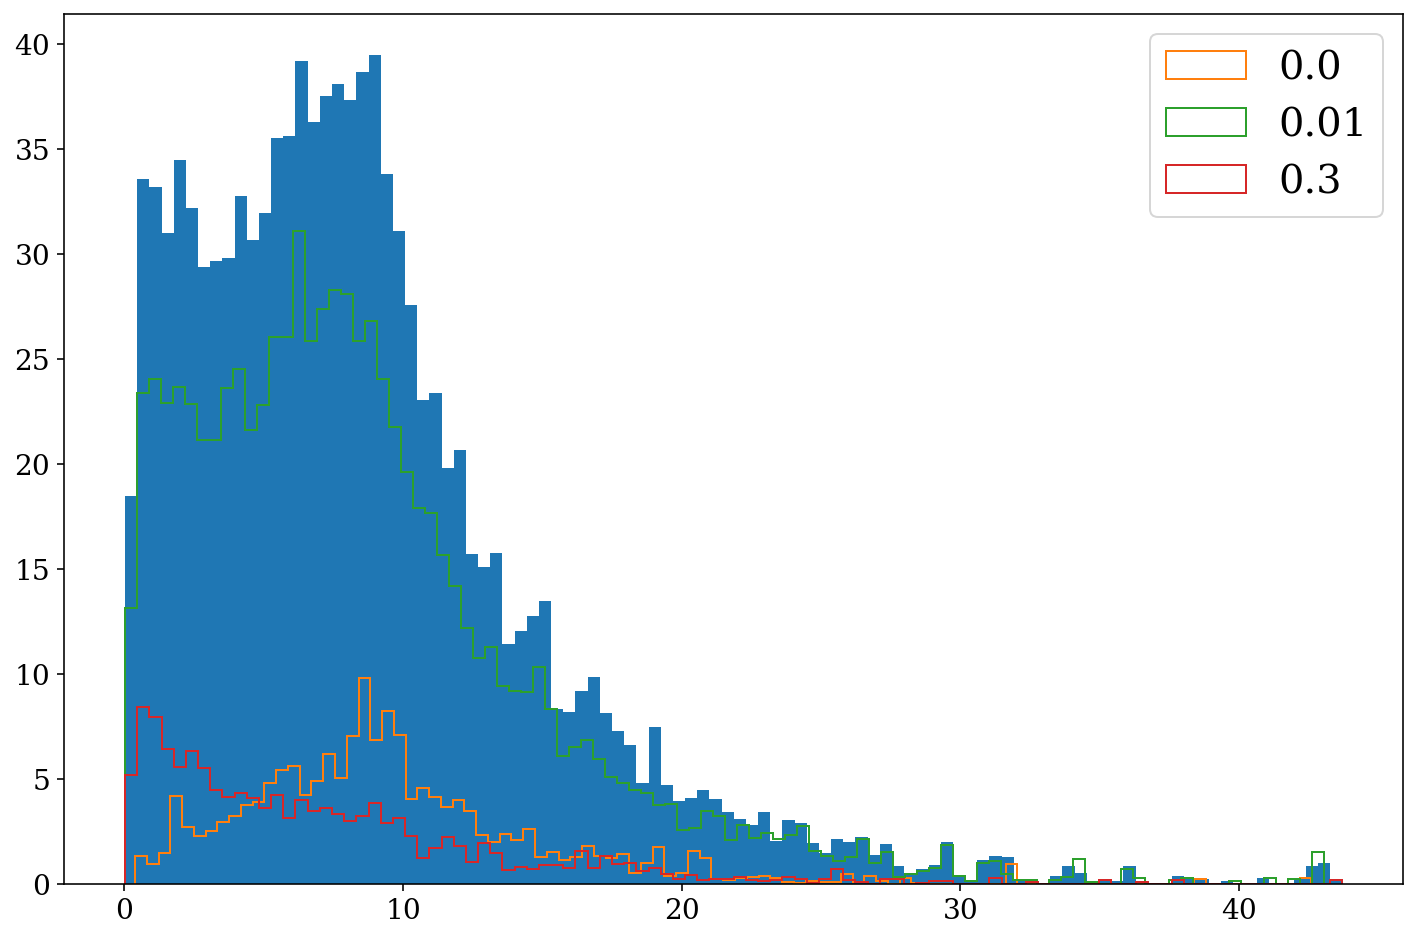

In [156]:
with h5.File(sim_folder + "{}_{}_all.h5".format("NSNS", "fiducial"), "r") as f:
    data = f["simulation"][...].squeeze()

density=False
    
plt.hist(data["dist"], weights=data["weight"], bins=100, density=density)

for lims in [(0.0, 0.01), (0.01, 0.3), (0.3, 1.0)]:
    mask = np.logical_and(data["e_LISA"] >= lims[0], data["e_LISA"] < lims[1])
    plt.hist(data["dist"][mask], weights=data["weight"][mask], bins=100, label=lims, histtype="step", density=density)
    
plt.legend()

plt.show()

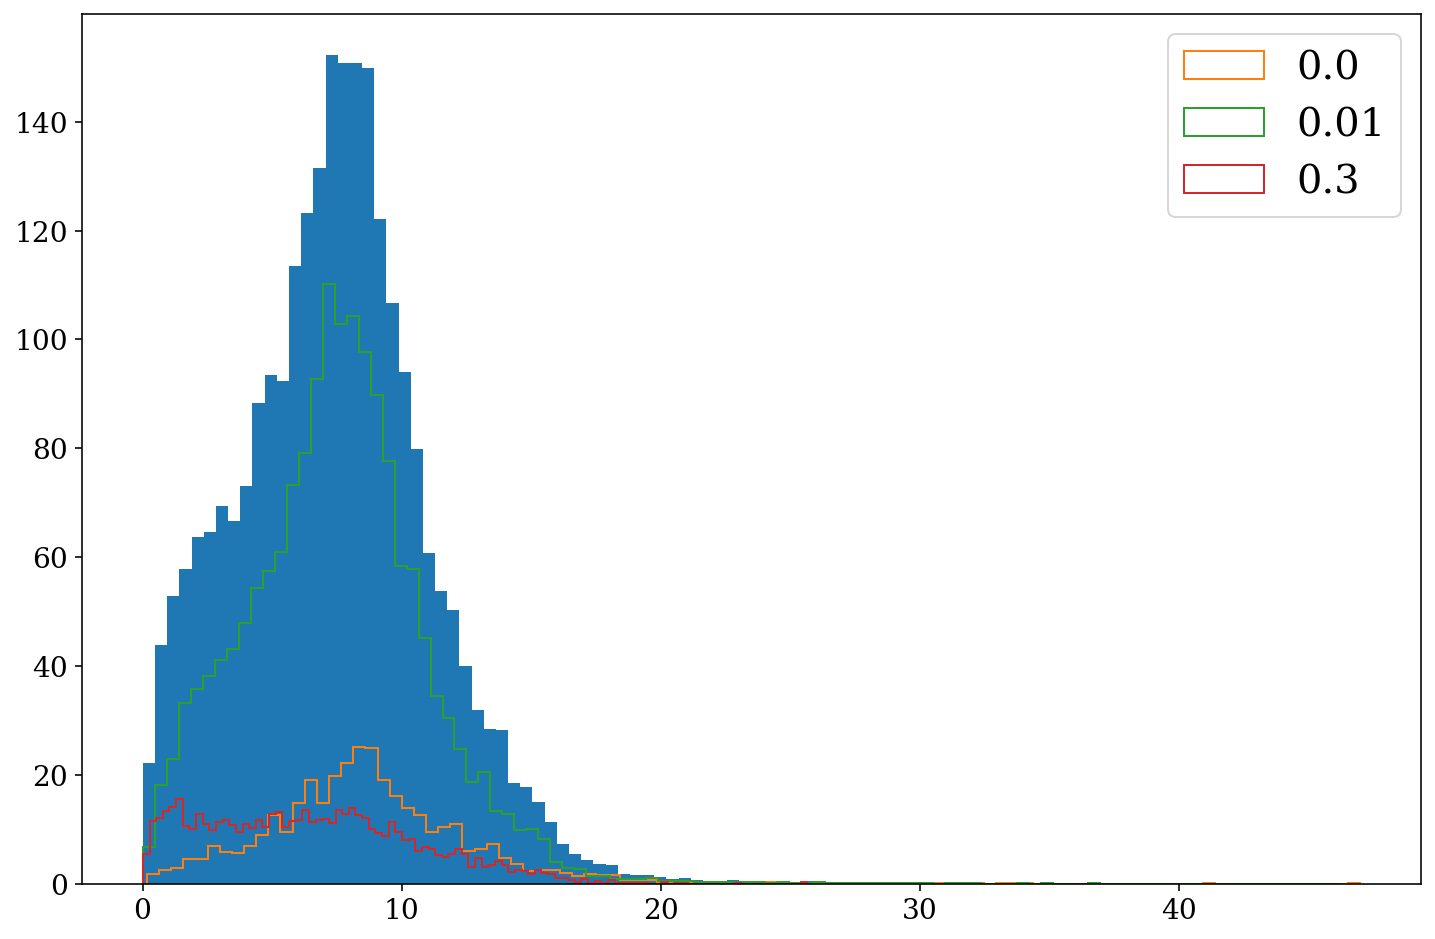

In [157]:
with h5.File(sim_folder + "{}_{}_all.h5".format("BHBH", "fiducial"), "r") as f:
    data = f["simulation"][...].squeeze()

density=False
    
plt.hist(data["dist"], weights=data["weight"], bins=100, density=density)

for lims in [(0.0, 0.01), (0.01, 0.3), (0.3, 1.0)]:
    mask = np.logical_and(data["e_LISA"] >= lims[0], data["e_LISA"] < lims[1])
    plt.hist(data["dist"][mask], weights=data["weight"][mask], bins=100, label=lims, histtype="step", density=density)
    
plt.legend()

plt.show()

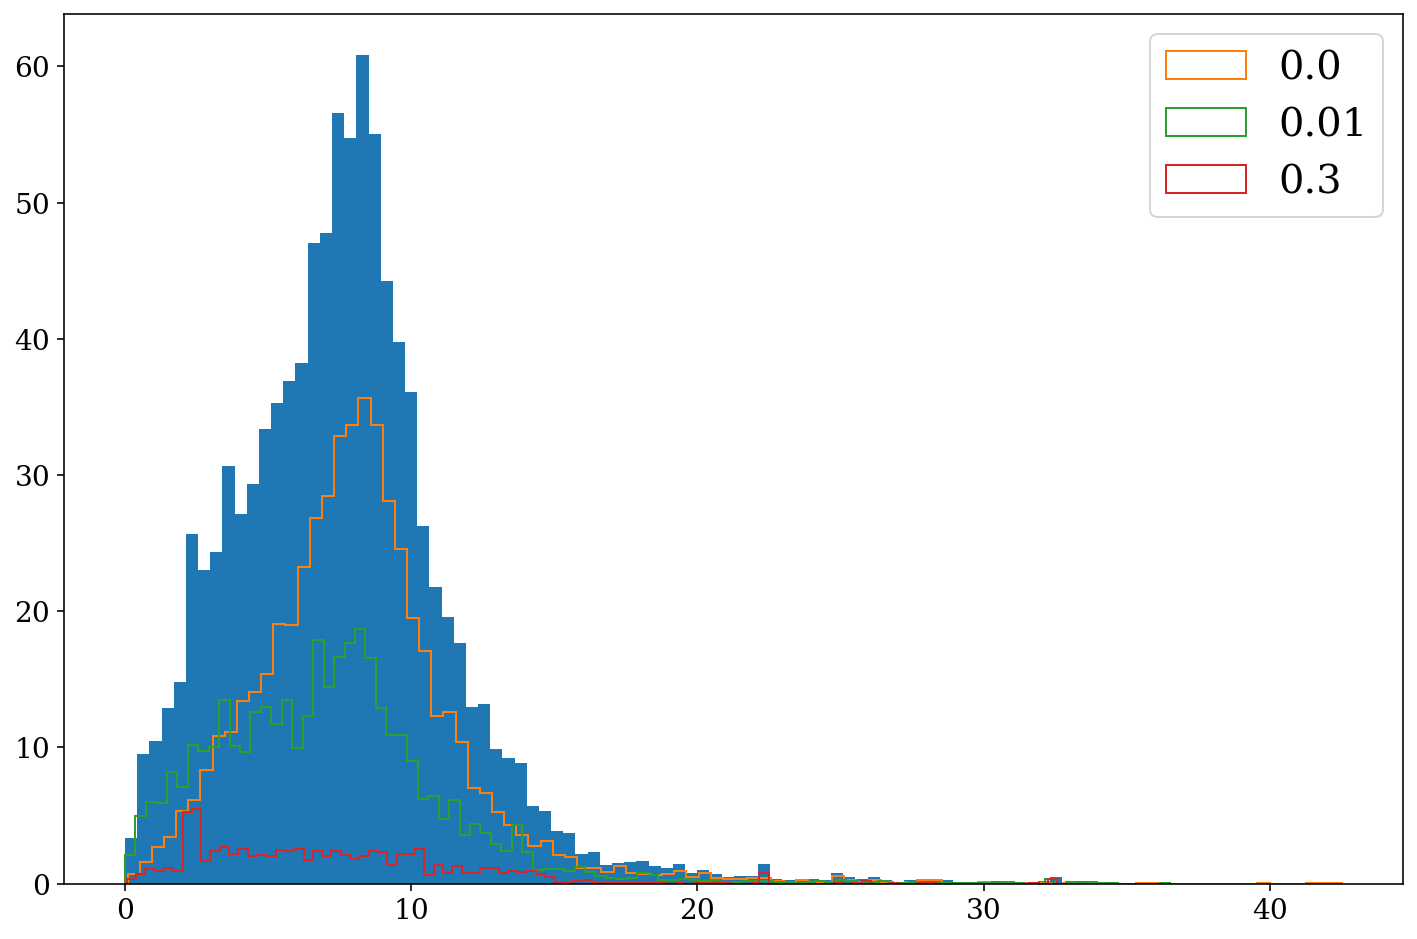

In [158]:
with h5.File(sim_folder + "{}_{}_all.h5".format("BHNS", "fiducial"), "r") as f:
    data = f["simulation"][...].squeeze()

density=False
    
plt.hist(data["dist"], weights=data["weight"], bins=100, density=density)

for lims in [(0.0, 0.01), (0.01, 0.3), (0.3, 1.0)]:
    mask = np.logical_and(data["e_LISA"] >= lims[0], data["e_LISA"] < lims[1])
    plt.hist(data["dist"][mask], weights=data["weight"][mask], bins=100, label=lims, histtype="step", density=density)
    
plt.legend()

plt.show()

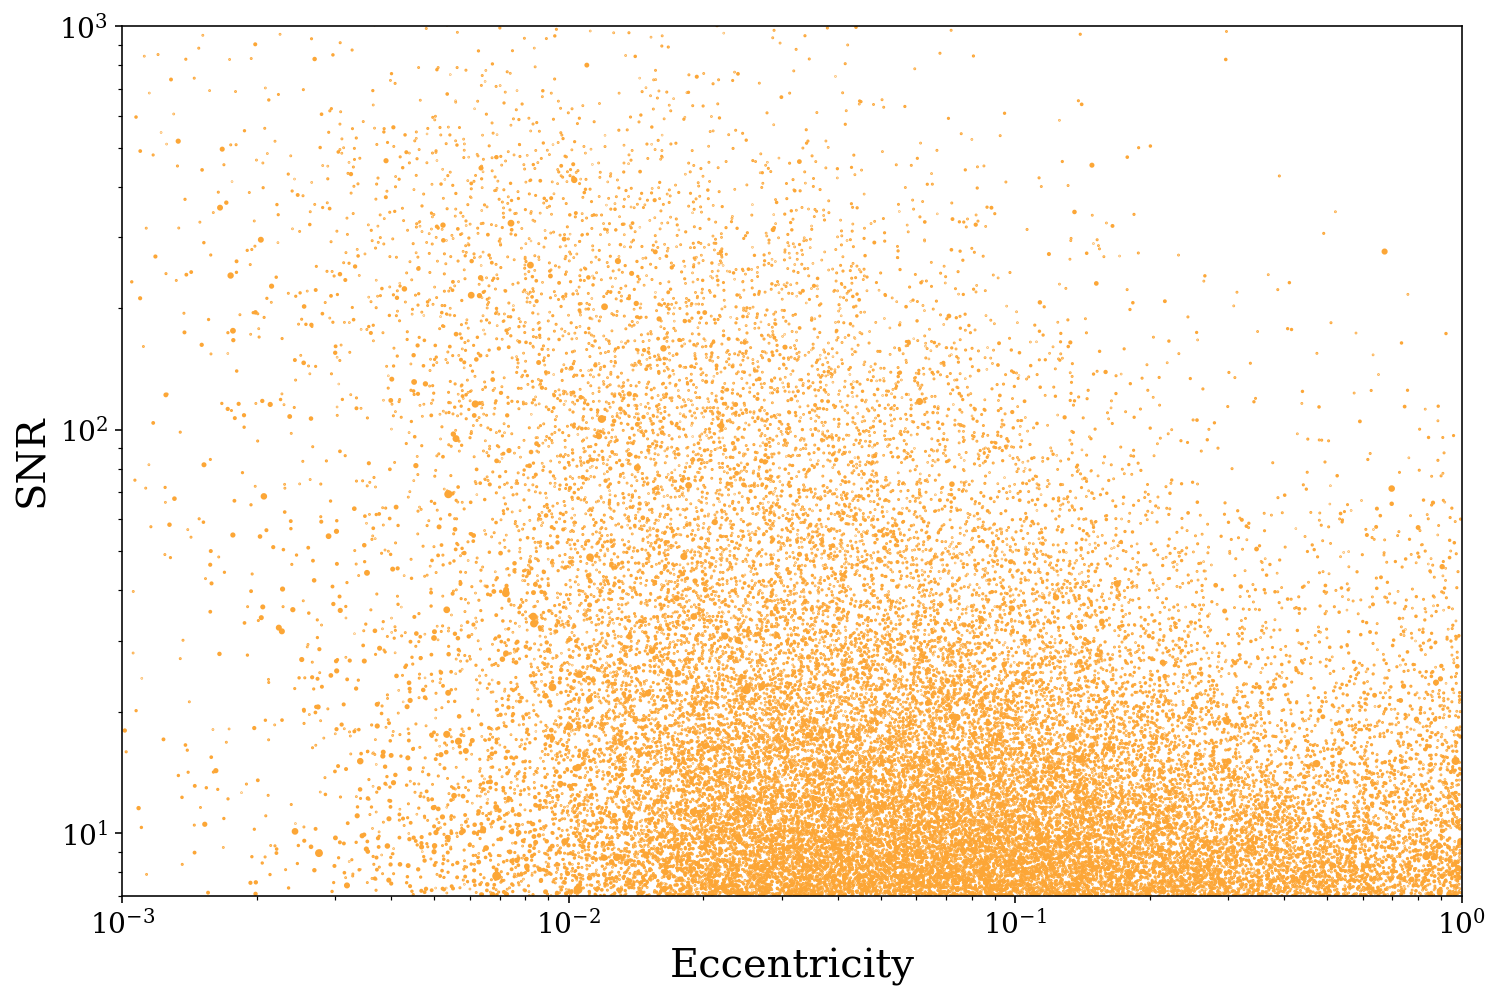

In [137]:
with h5.File(sim_folder + "{}_{}_all.h5".format("NSNS", "fiducial"), "r") as f:
    data = f["simulation"][...].squeeze()

f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                              a=data["a_LISA"] * u.AU)

plt.scatter(data["e_LISA"], data["snr"], s=data["weight"] * 10, color=dco_colours[dco_type])
#     sns.kdeplot(x=data["e_LISA"], y=data["snr"], weights=data["weight"], log_scale=(True, True), color=dco_colours[dco_type])

plt.xscale("log")
plt.yscale("log")
plt.ylim(7, 1e3)
plt.xlim(1e-3, 1e0)

plt.xlabel("Eccentricity")
plt.ylabel("SNR")

plt.show()

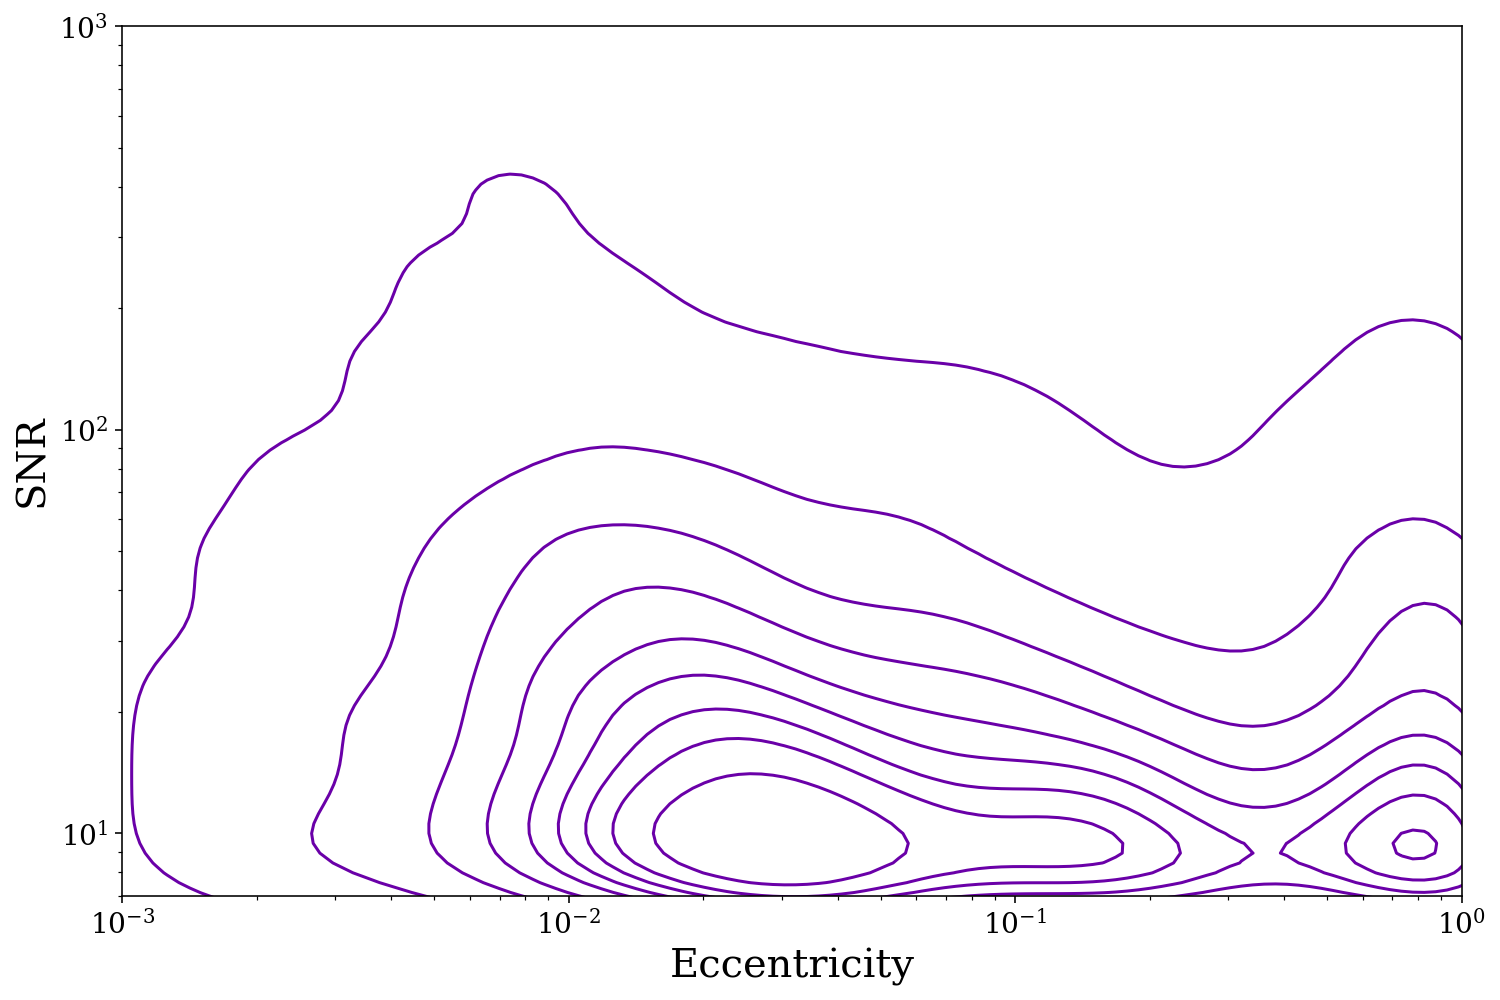

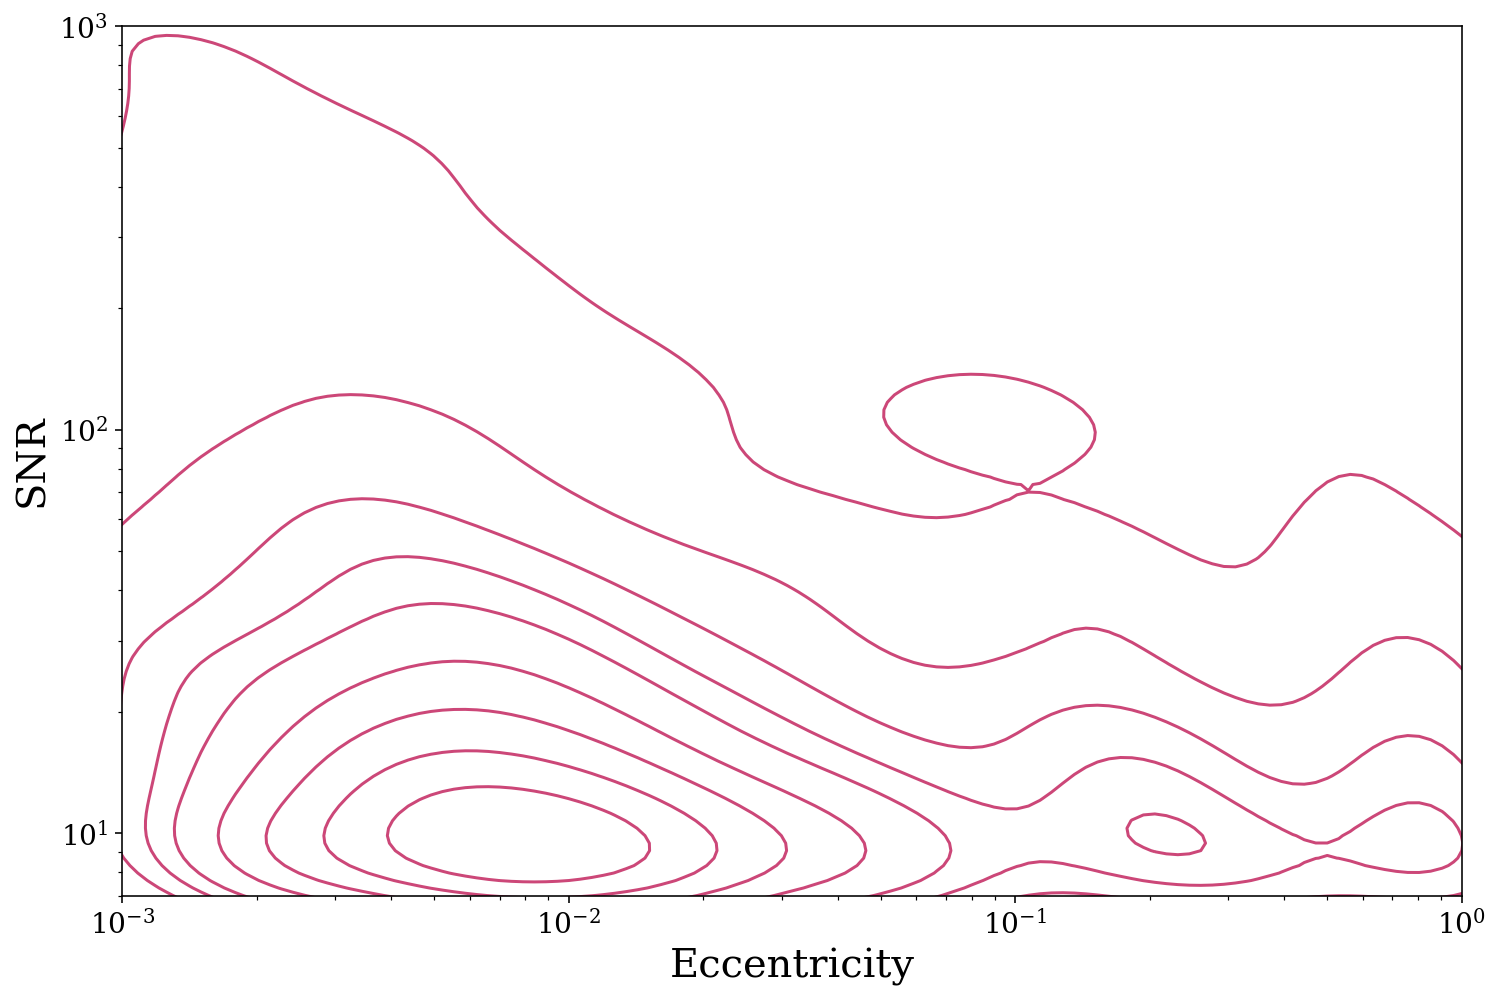

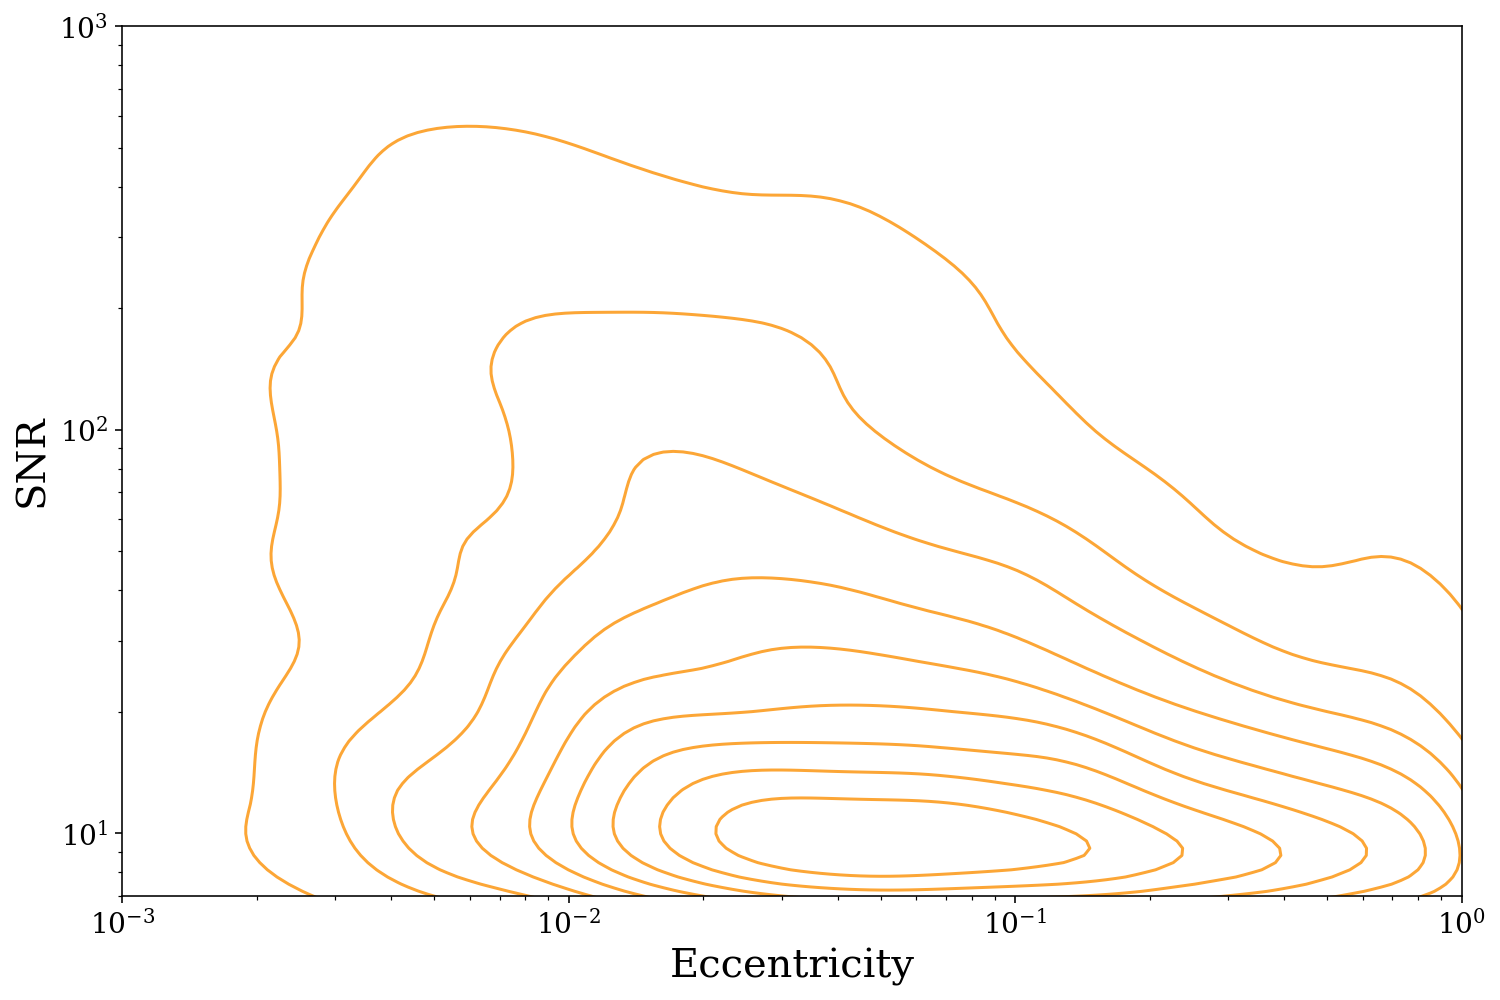

In [95]:
for i, dco_type in enumerate(dco_types):
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, "fiducial"), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * np.sqrt(t_obs / (4 * u.yr)) > detection_threshold
        data = full_data[snr_mask]
        
    f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                  a=data["a_LISA"] * u.AU)
    
#     plt.scatter(data["e_LISA"], data["snr"], s=data["weight"] * 10, color=dco_colours[dco_type])
    sns.kdeplot(x=data["e_LISA"], y=data["snr"], weights=data["weight"], log_scale=(True, True), color=dco_colours[dco_type])
    
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(7, 1e3)
    plt.xlim(1e-3, 1e0)
    
    plt.xlabel("Eccentricity")
    plt.ylabel("SNR")

    plt.show()

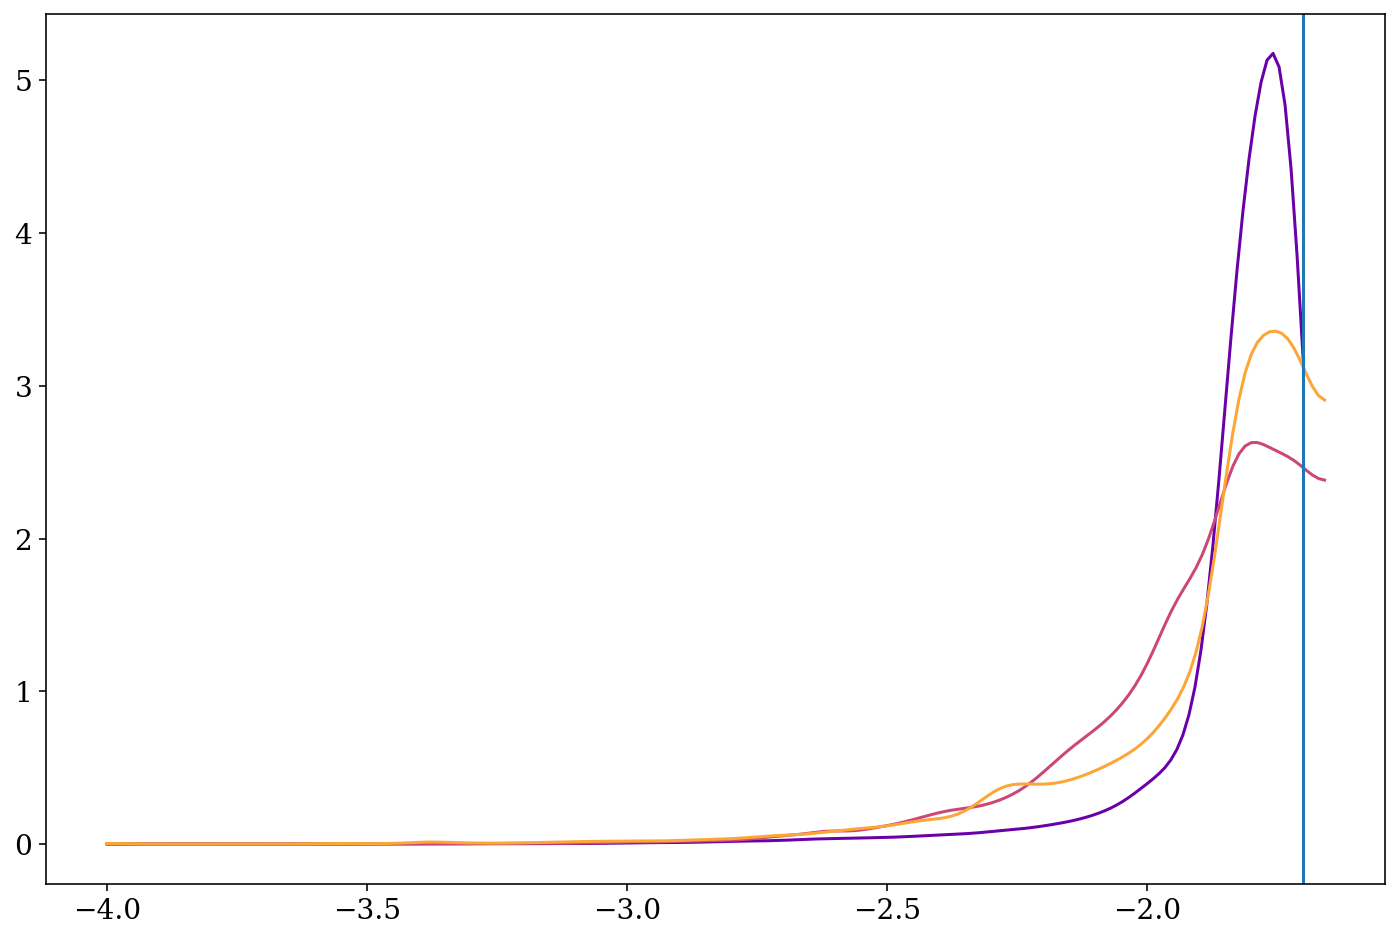

In [33]:
for dco_type in dco_types:

    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, "fiducial"), "r") as f:
        data = f["simulation"][...].squeeze()

    density=True
    
    plt.plot(*boots.kde(np.log10(data["Z"]), weights=data["weight"], lower_bound=-4, upper_bound=np.log10(0.022)), color=dco_colours[dco_type])

# for lims in [(0.0, 0.01), (0.01, 0.3), (0.3, 1.0)]:
#     mask = np.logical_and(data["e_LISA"] >= lims[0], data["e_LISA"] < lims[1])
#     plt.hist(data["dist"][mask], weights=data["weight"][mask], bins=100, label=lims, histtype="step", density=density)
    
# plt.legend()

# plt.yscale("log")

plt.axvline(np.log10(0.02))

plt.show()

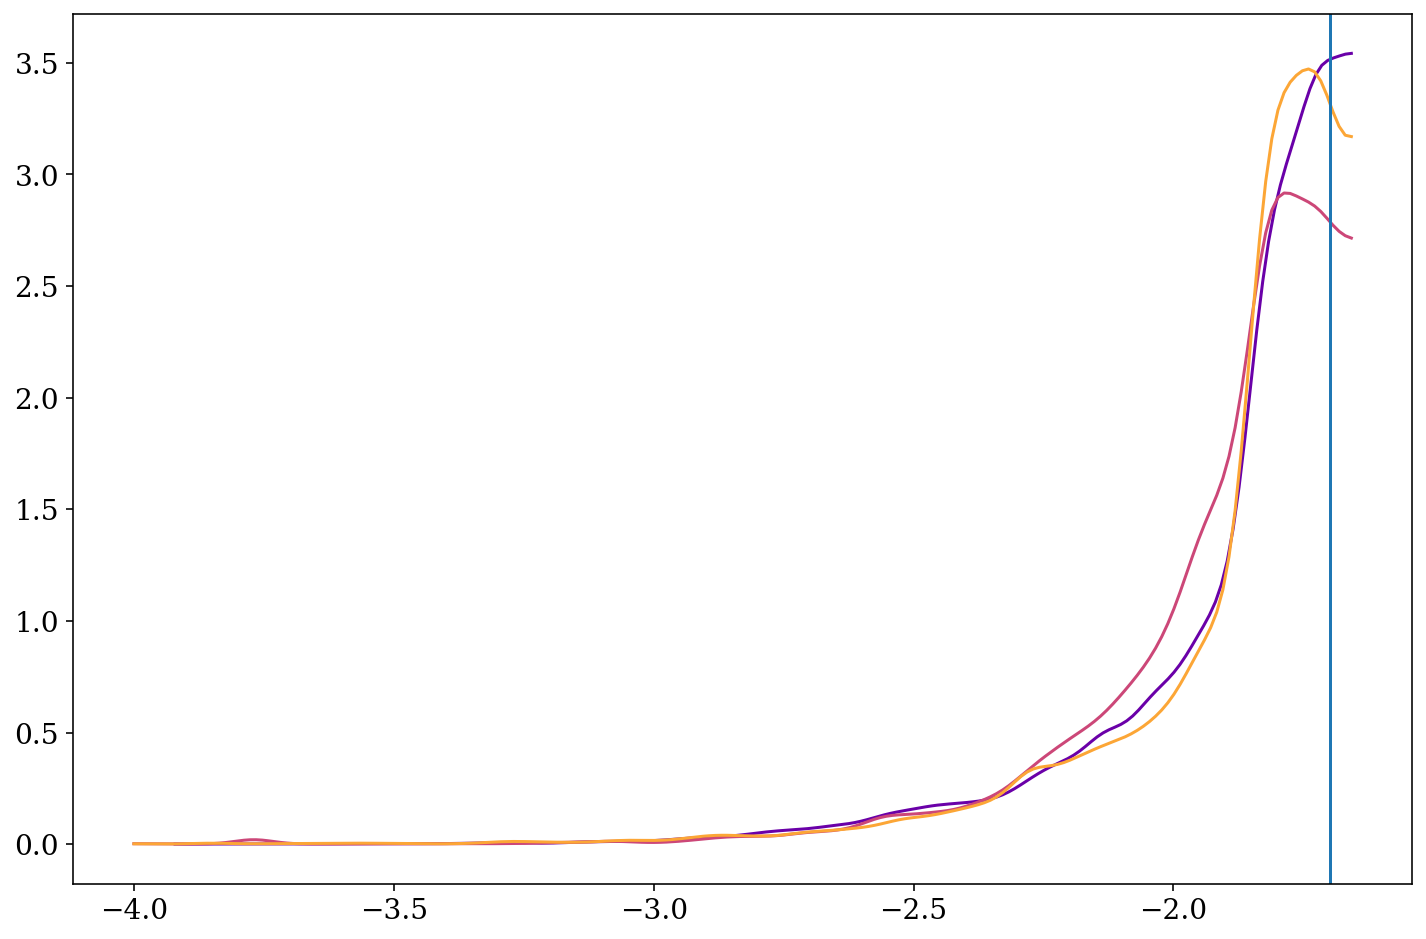

In [38]:
for dco_type in dco_types:

    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, "wolf_rayet_multiplier_0_1"), "r") as f:
        data = f["simulation"][...].squeeze()

    density=True
    
    plt.plot(*boots.kde(np.log10(data["Z"]), weights=data["weight"], lower_bound=-4, upper_bound=np.log10(0.022)), color=dco_colours[dco_type])

# for lims in [(0.0, 0.01), (0.01, 0.3), (0.3, 1.0)]:
#     mask = np.logical_and(data["e_LISA"] >= lims[0], data["e_LISA"] < lims[1])
#     plt.hist(data["dist"][mask], weights=data["weight"][mask], bins=100, label=lims, histtype="step", density=density)
    
# plt.legend()

# plt.yscale("log")

plt.axvline(np.log10(0.02))

plt.show()